In [53]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [9]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [25]:
# This is the shorter way of doing what is above, separate file names 
island_name, date = image_filename.split("_")

In [26]:
island_name

'tor'

In [10]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [37]:

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract the filename without extension
    image_filename = os.path.splitext(os.path.basename(image_path))[0]
    
    # Search for a shapefile with the same filename
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if os.path.splitext(os.path.basename(shapefile))[0] == image_filename]
    
    # If a matching shapefile is found, add the pair to the dictionary
    if matching_shapefiles:
        file_pairs[image_path] = matching_shapefiles[0]
        

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


In [38]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue
    
    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue
    
    # Assuming there's only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]
    
    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


Image: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\images\moff_20230717_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\moff_20230717_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\images\pal_20230714_image.tif

In [39]:
# Double check the shapefiles all have the same column names to avoid further issues 

import fiona

# Iterate through shapefile paths
for shapefile_path in shapefile_paths:
    # Open the shapefile
    with fiona.open(shapefile_path) as shp:
        # Print the column names
        print(f"Shapefile: {shapefile_path}")
        print("Column names:", shp.schema['properties'].keys())
        print()


Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230731_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230923_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\moff_20230717_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\pal_20230714_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\pal_20230720_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_d

In [52]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [54]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)


In [55]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

In [56]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [57]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

  freshwater       0.99      0.98      0.99     32859
         ice       1.00      1.00      1.00    210671
       ocean       1.00      1.00      1.00    798880
        rock       1.00      0.99      1.00     30026
       stain       0.00      0.00      0.00        20
walrus_mixed       0.98      0.28      0.43       167
 walrus_pure       1.00      0.82      0.90        57

    accuracy                           1.00   1072680
   macro avg       0.85      0.72      0.76   1072680
weighted avg       1.00      1.00      1.00   1072680


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [58]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


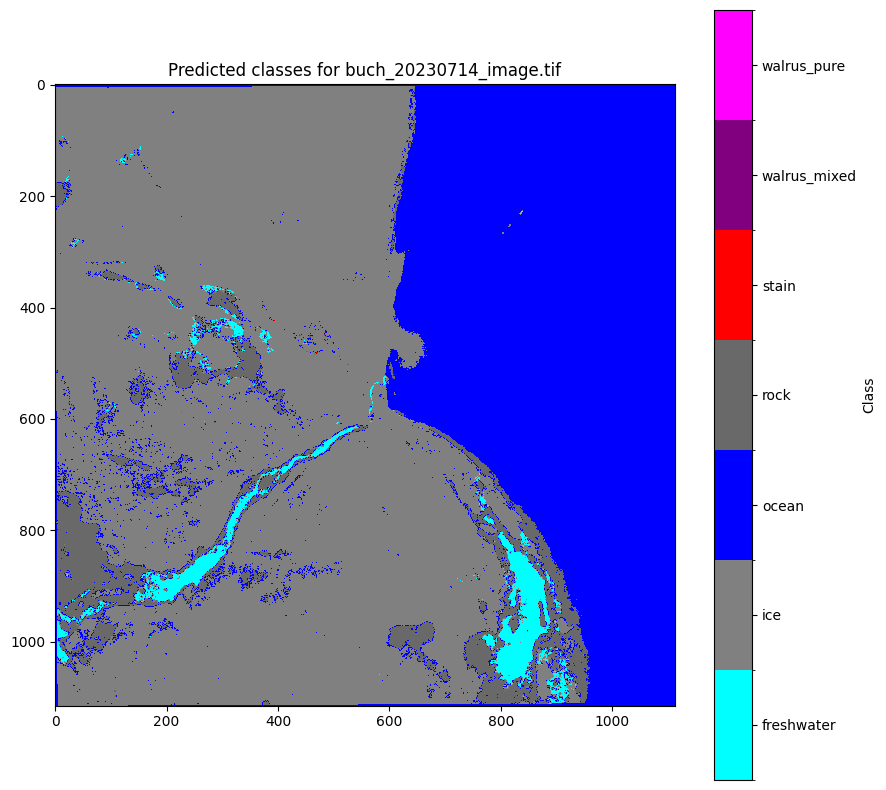

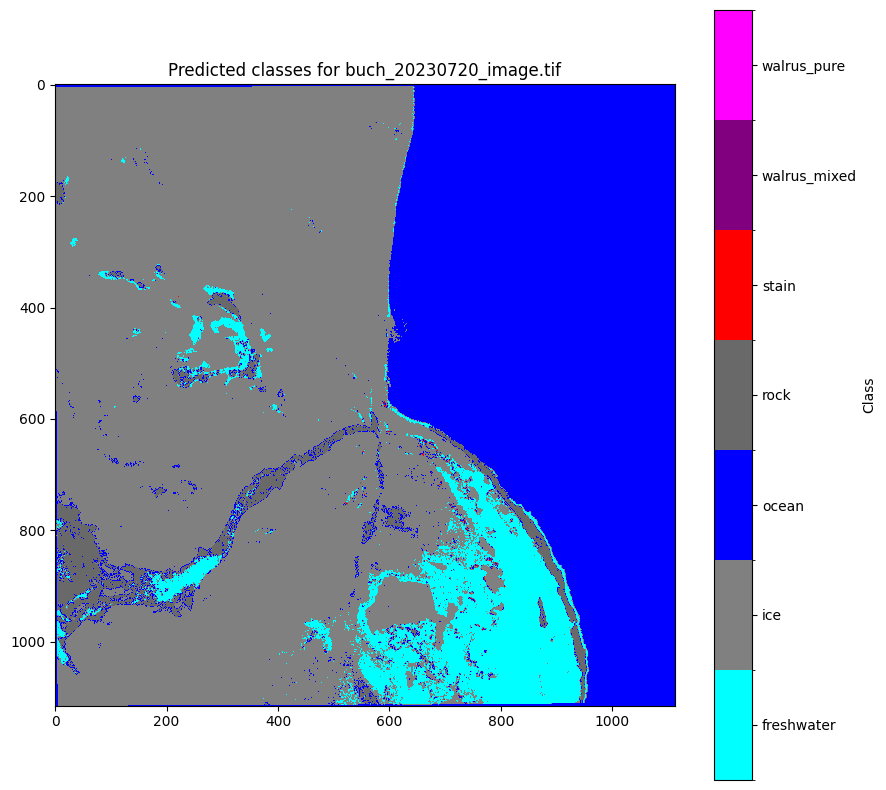

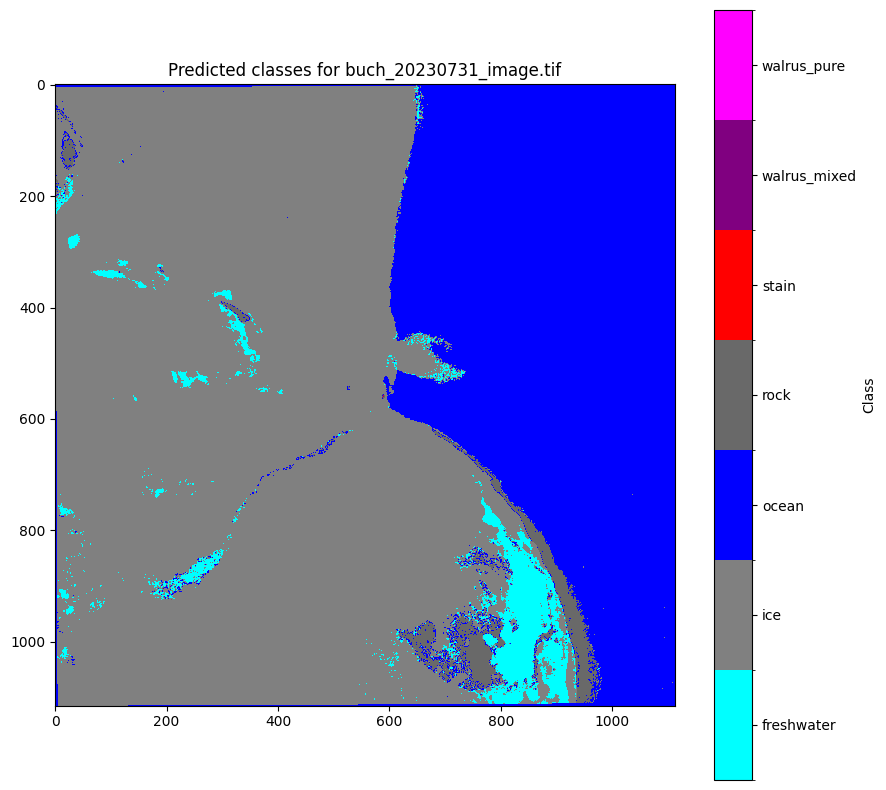

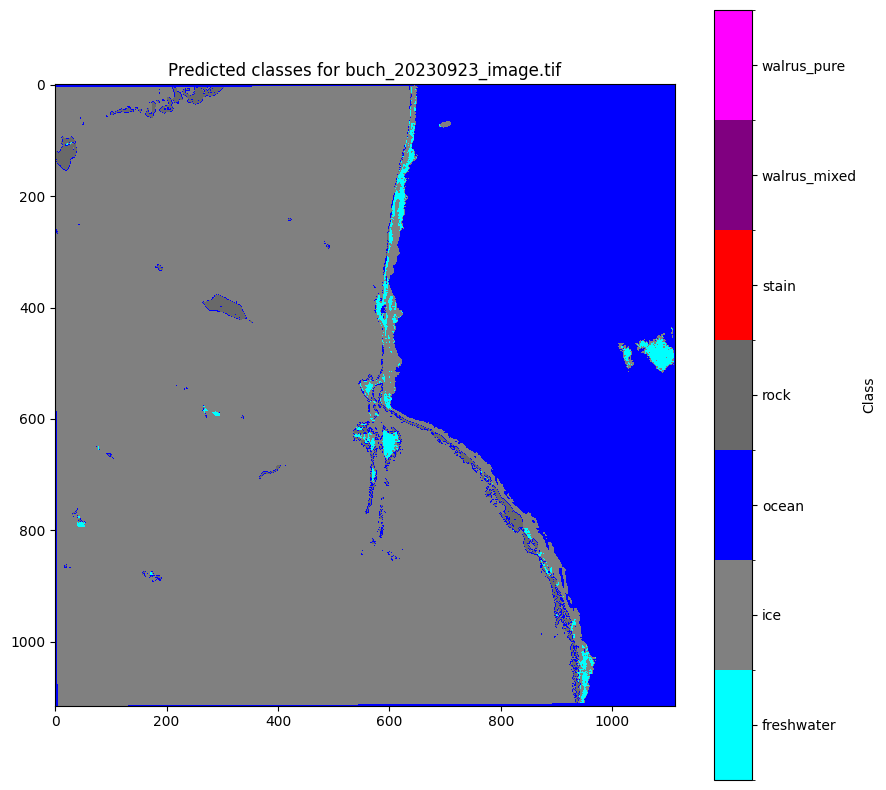

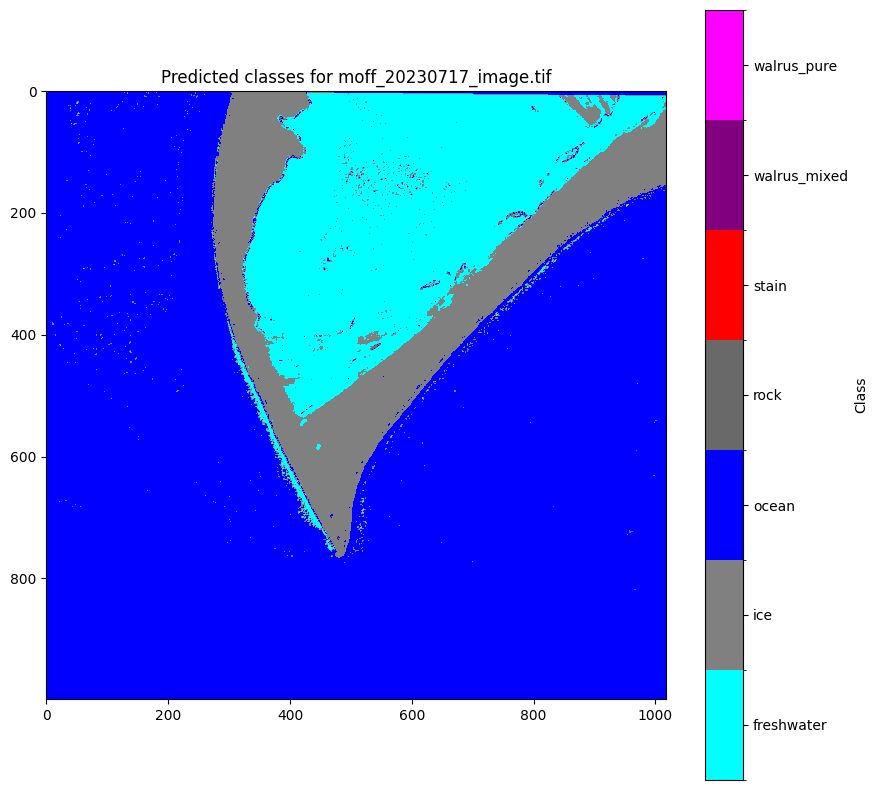

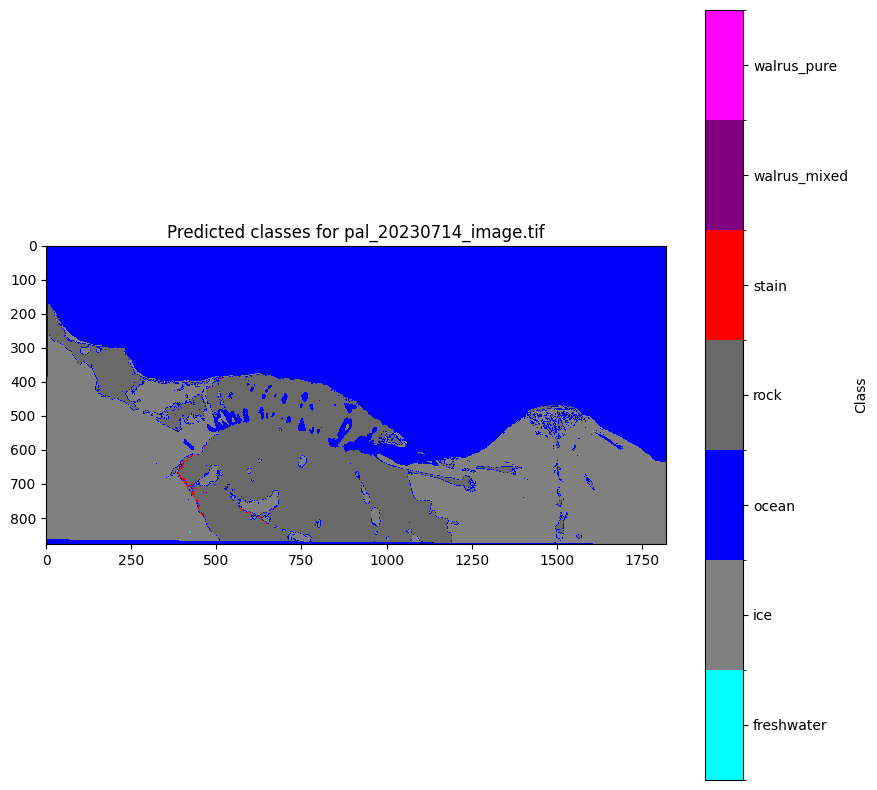

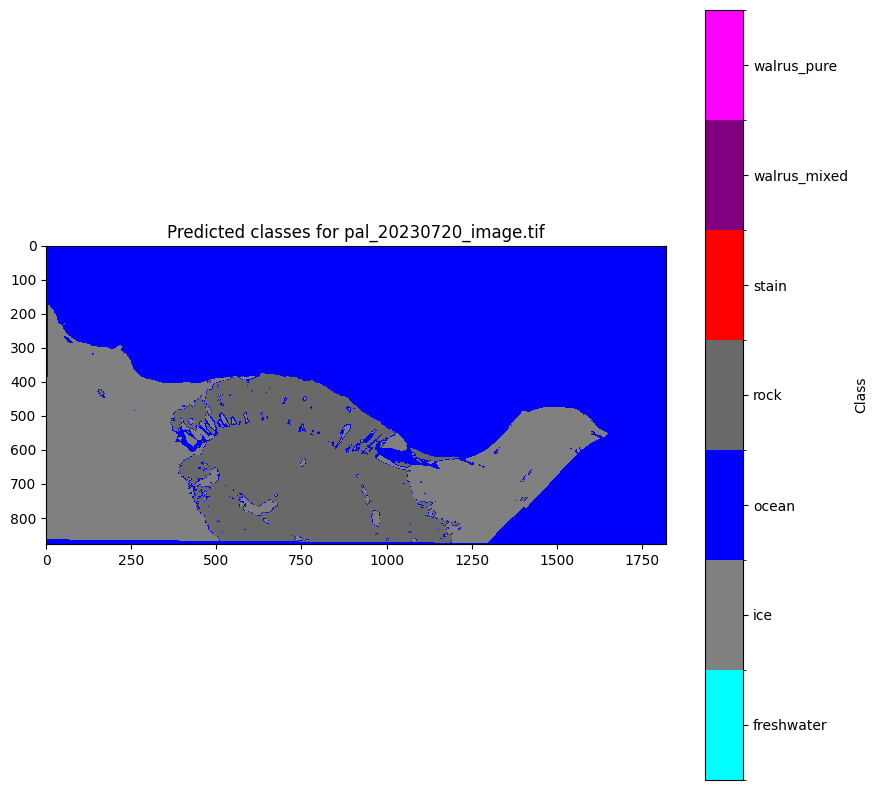

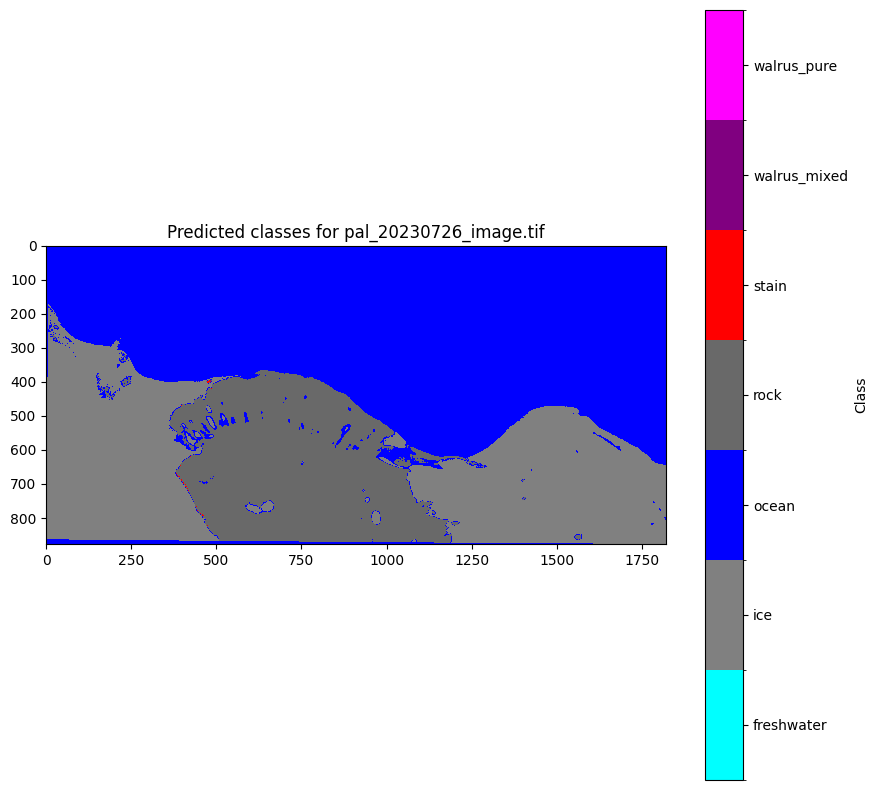

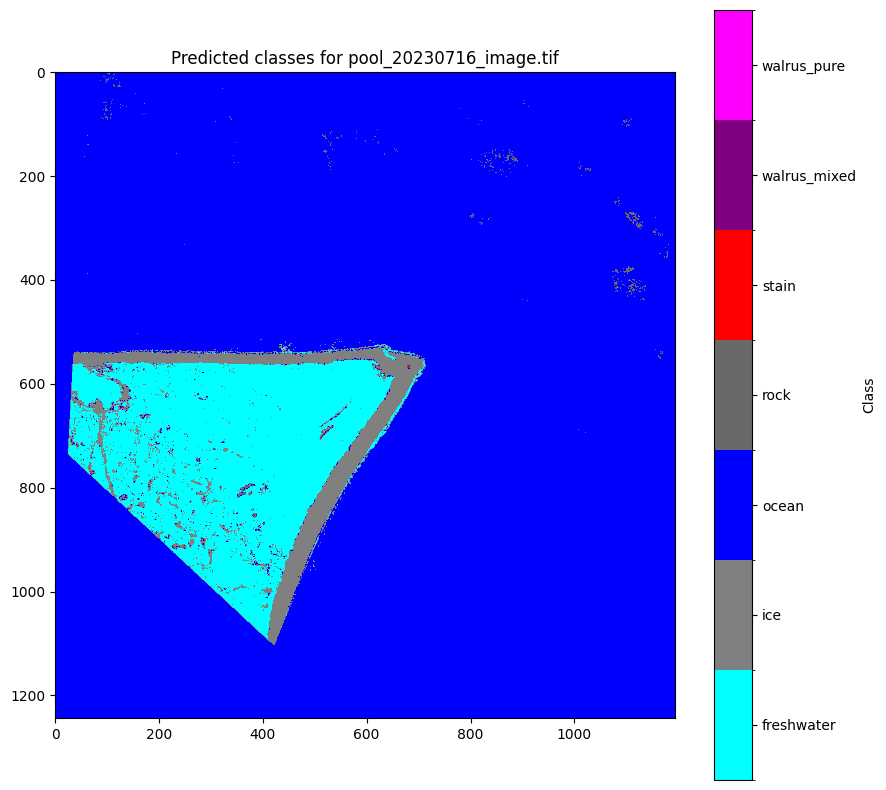

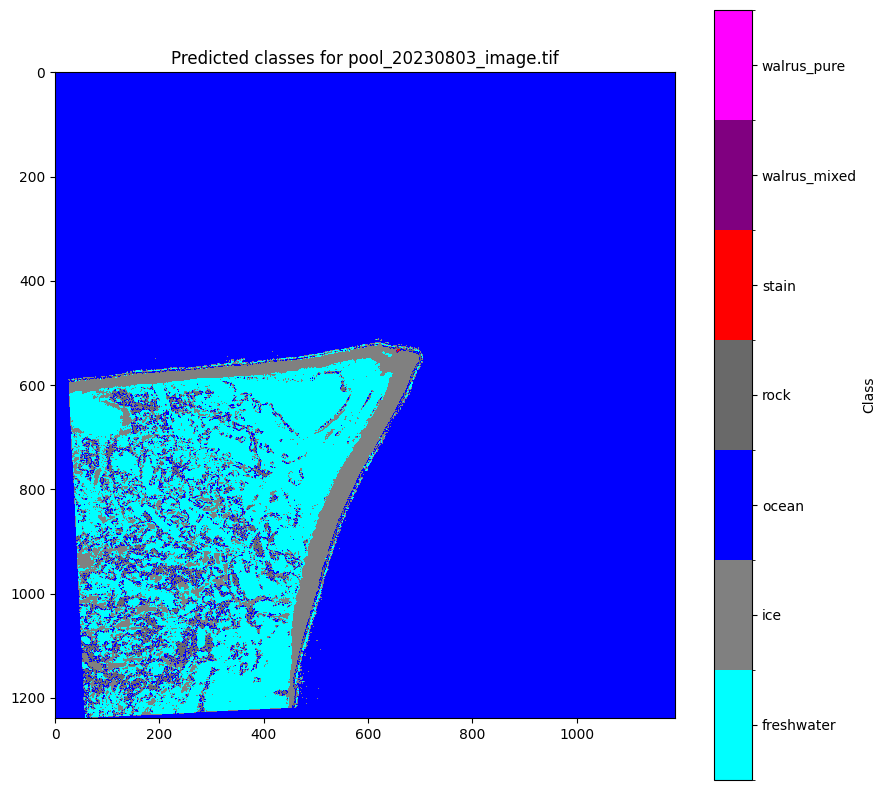

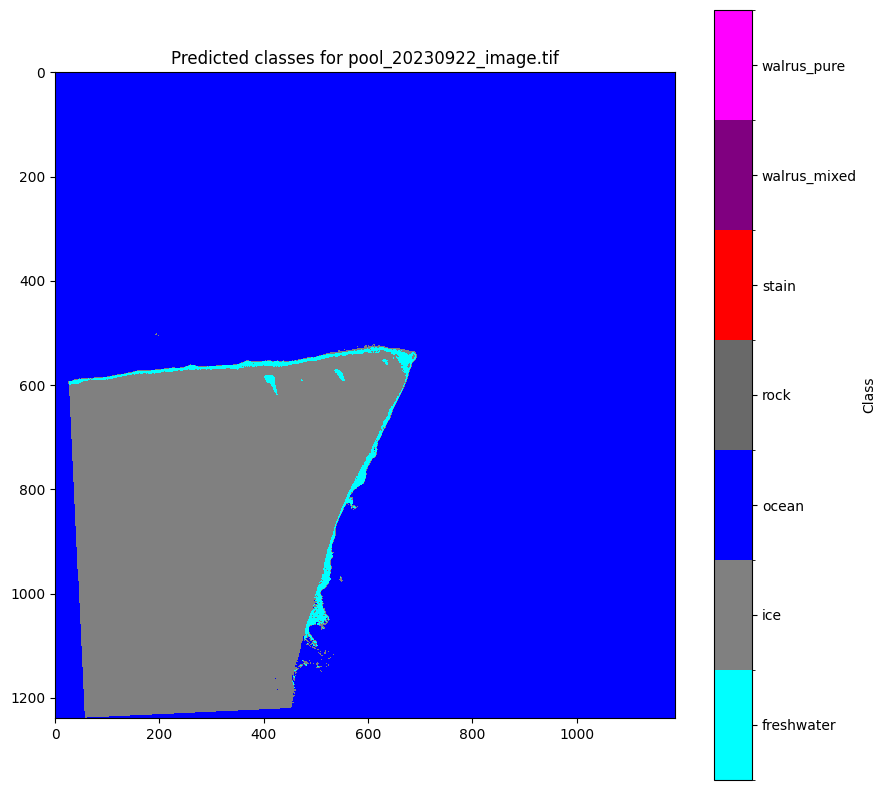

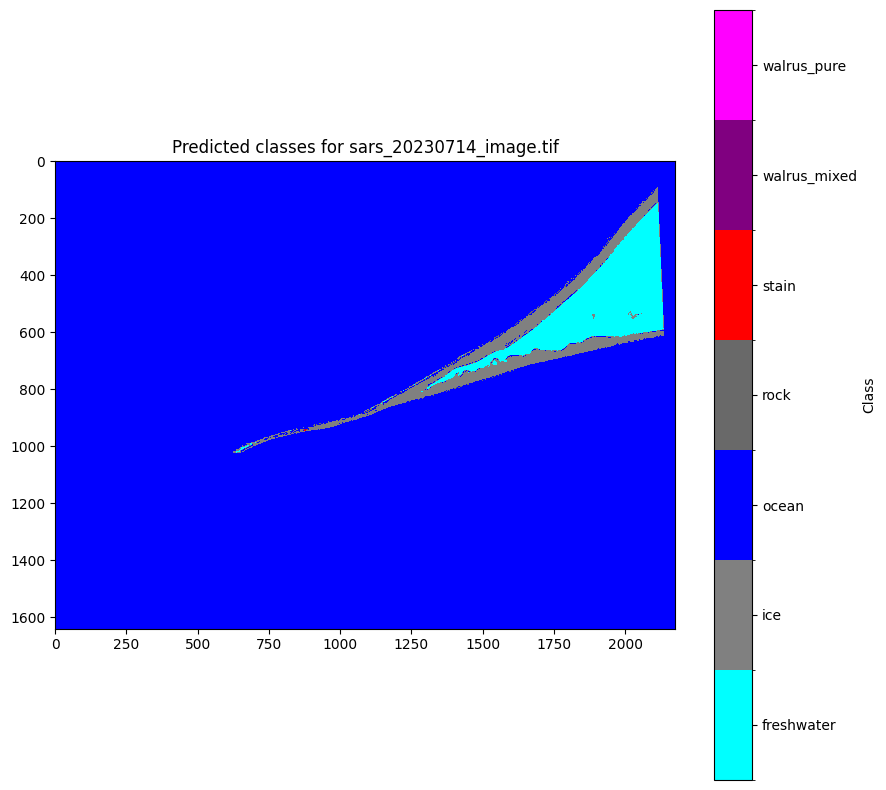

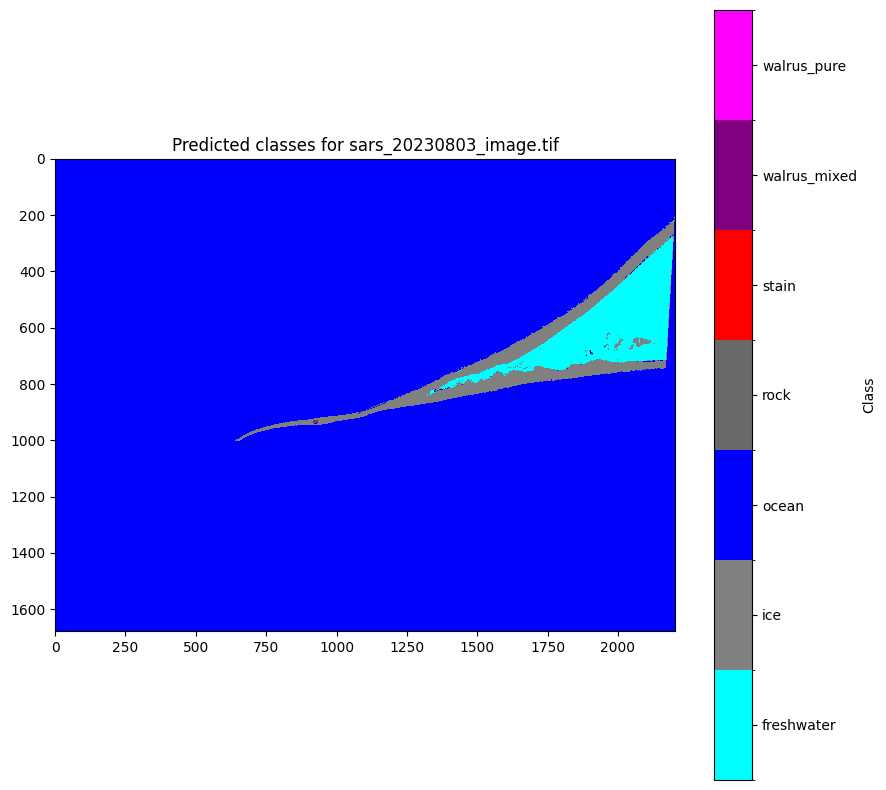

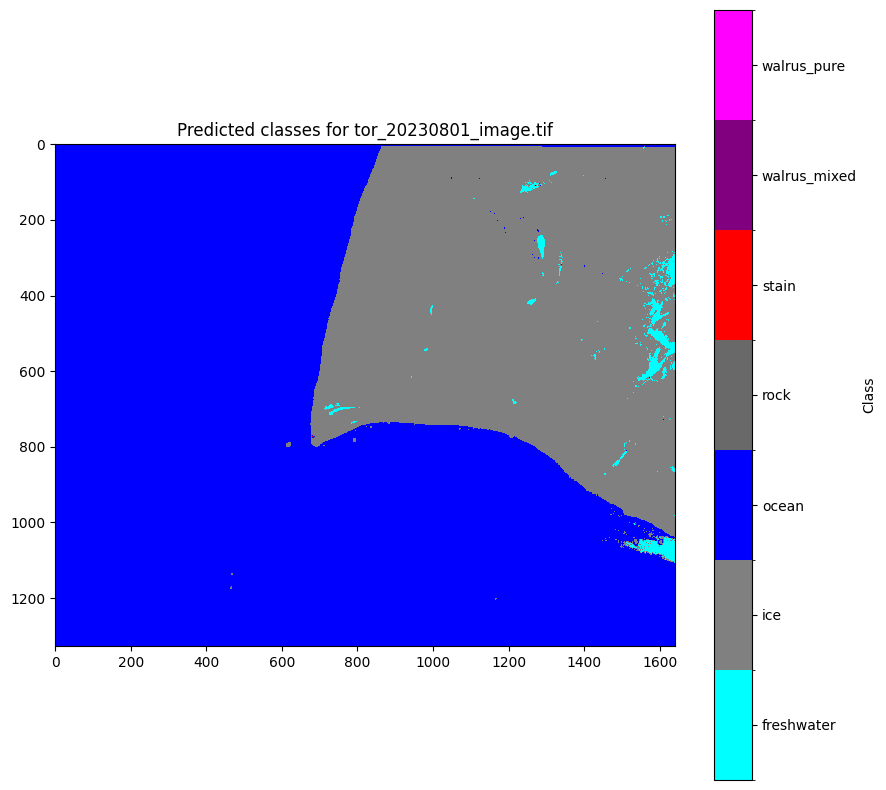

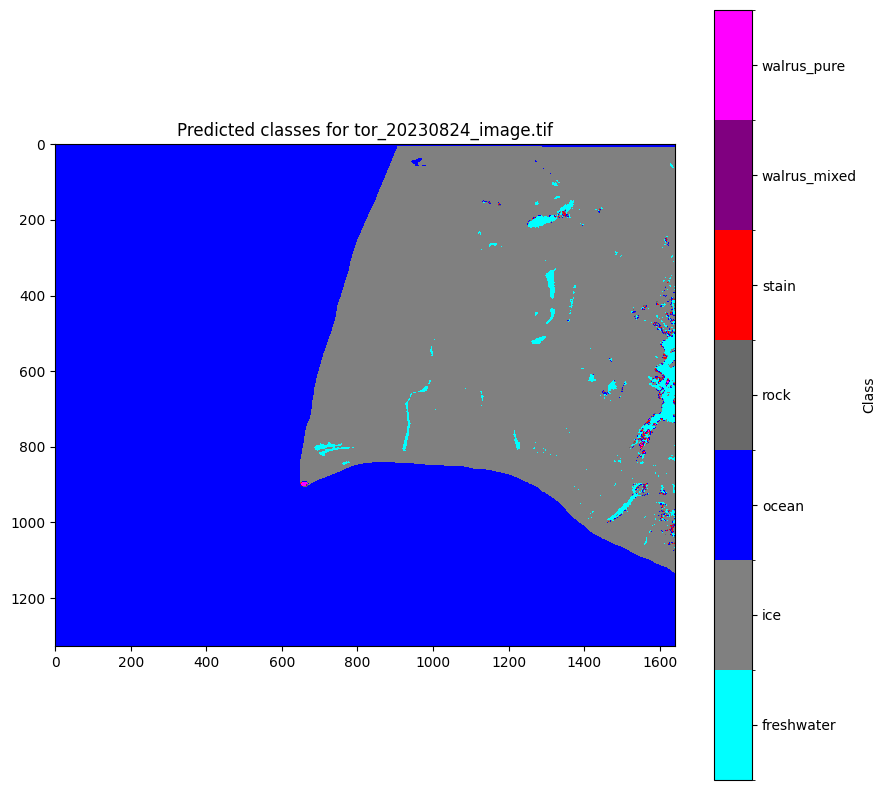

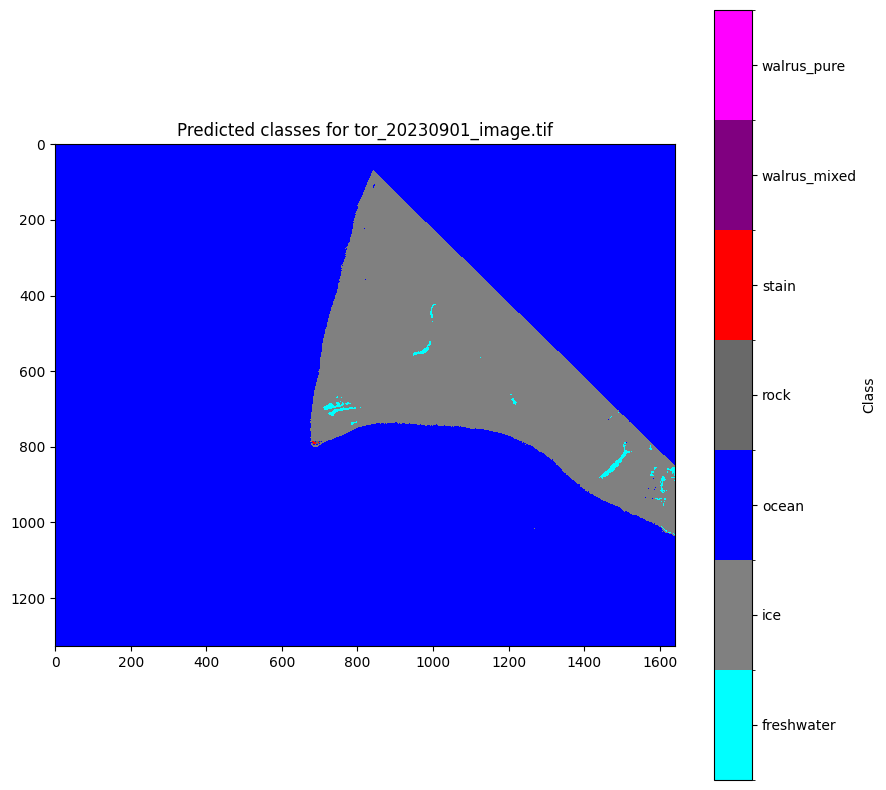

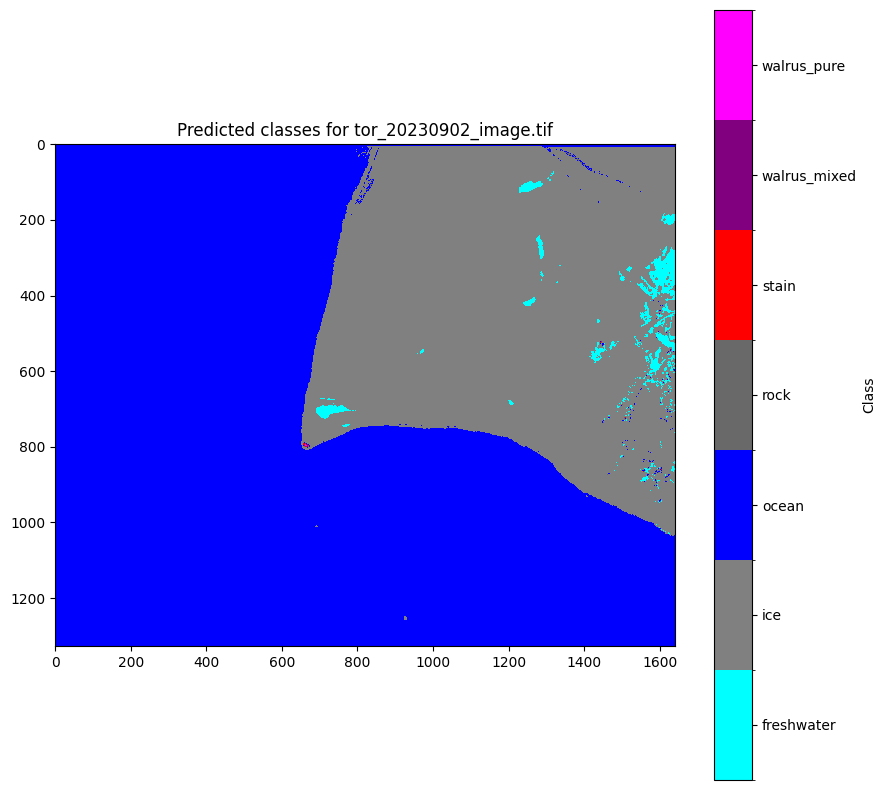

In [63]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a color map for the labels
label_colors = {'ice': 'gray', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue', 'stain': 'red'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(le.classes_)+1)-0.5, ncolors=len(le.classes_))

for image_path, predicted_image in predicted_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    plt.show()


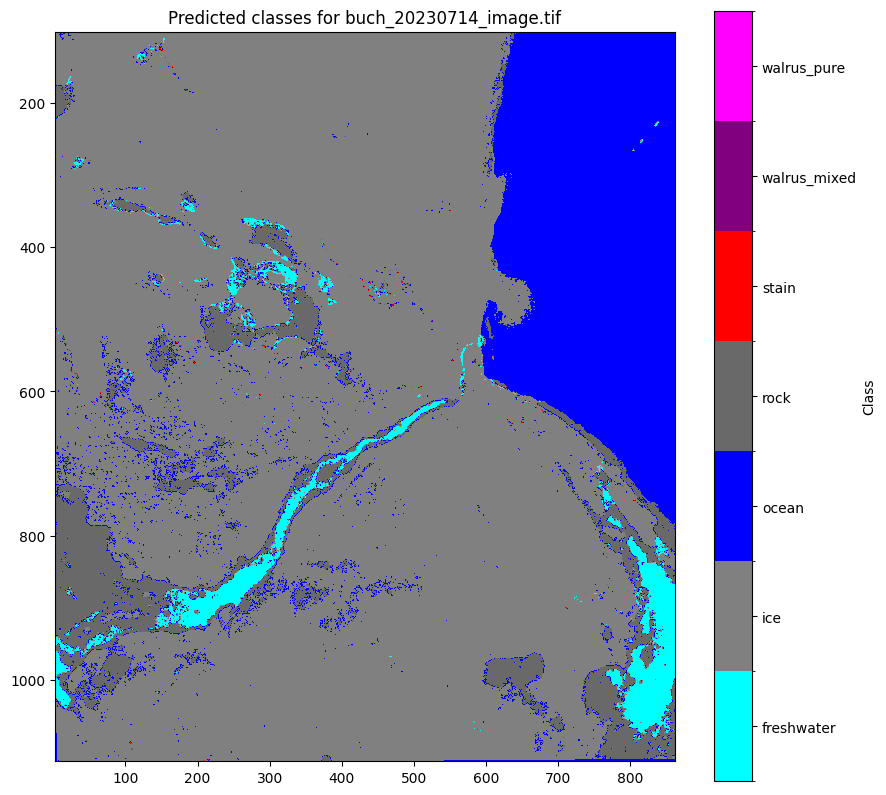

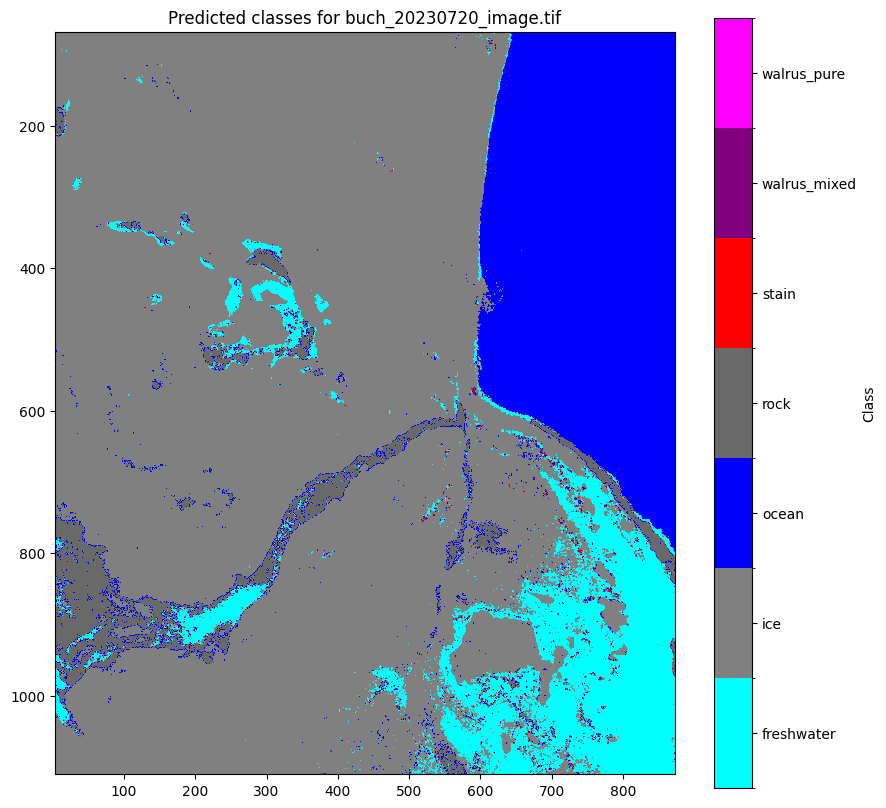

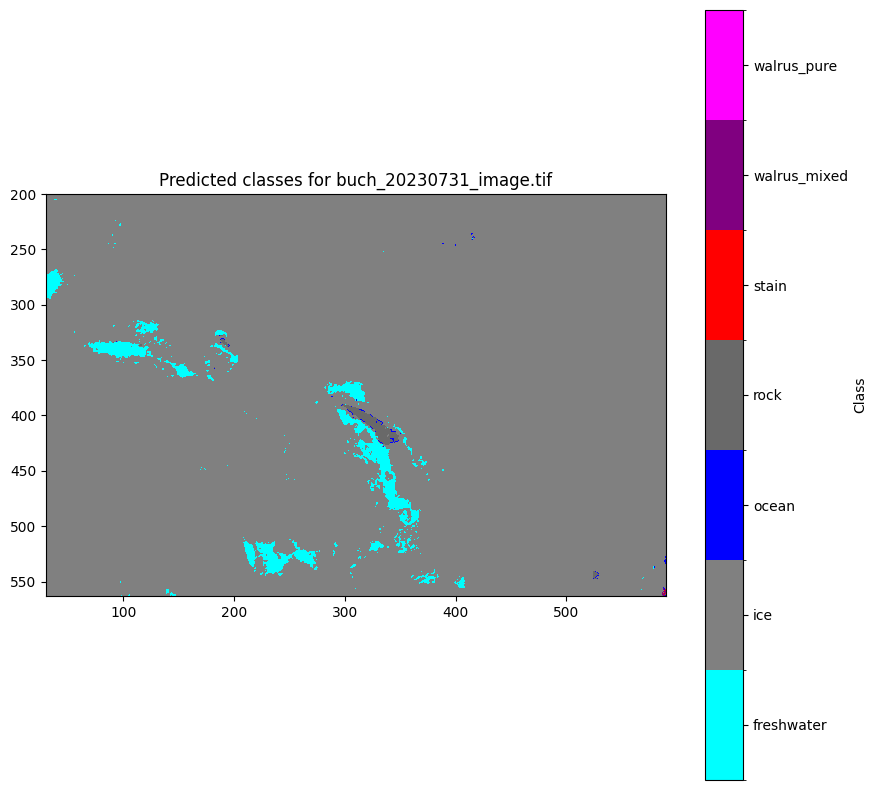

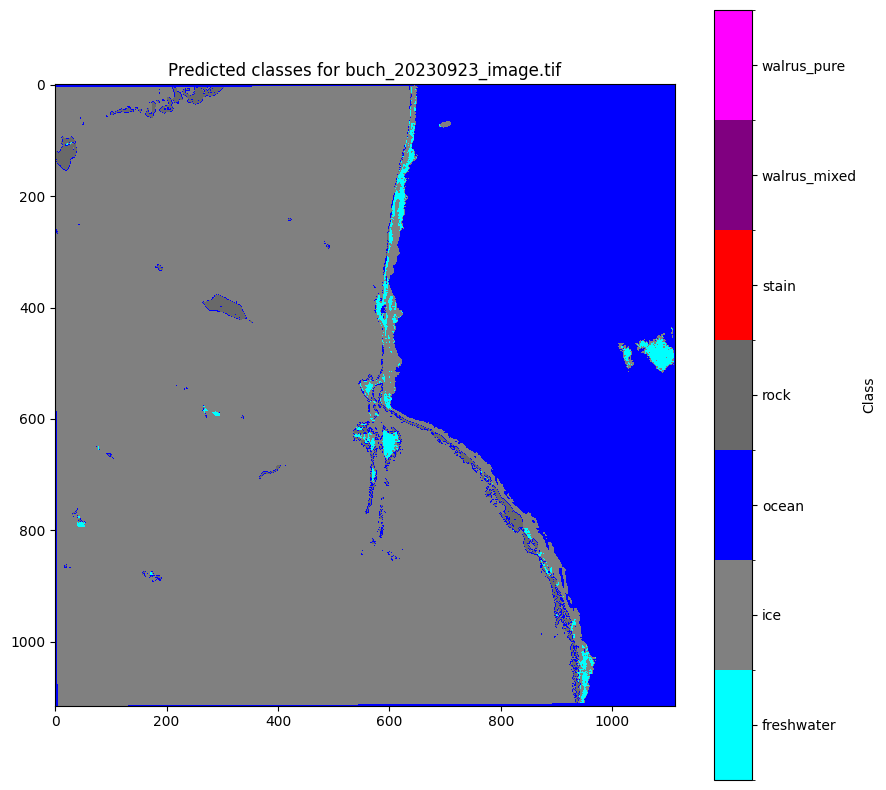

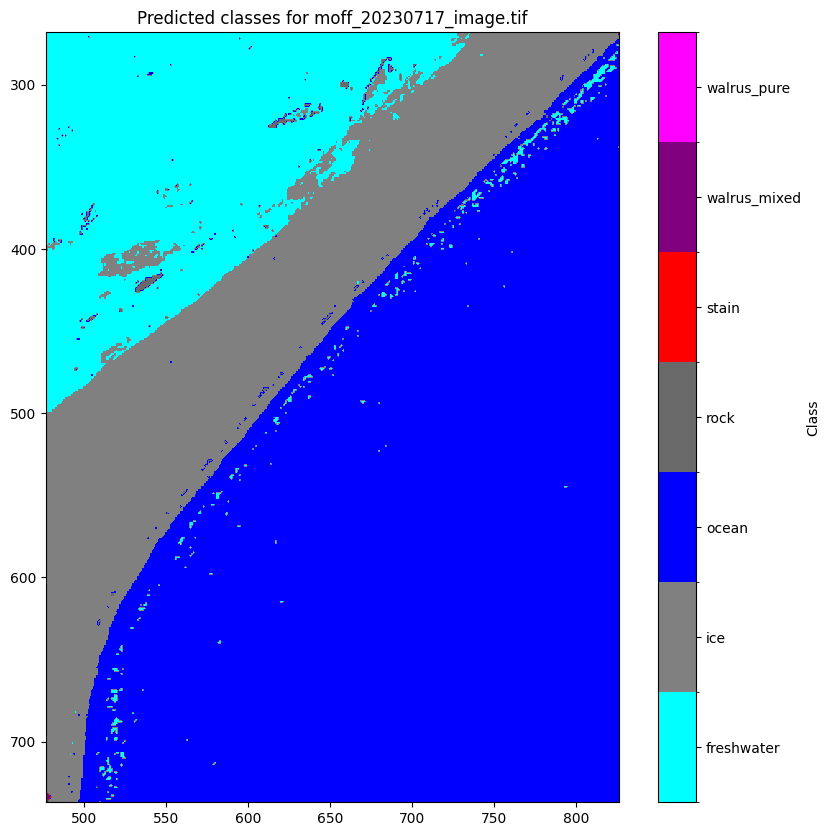

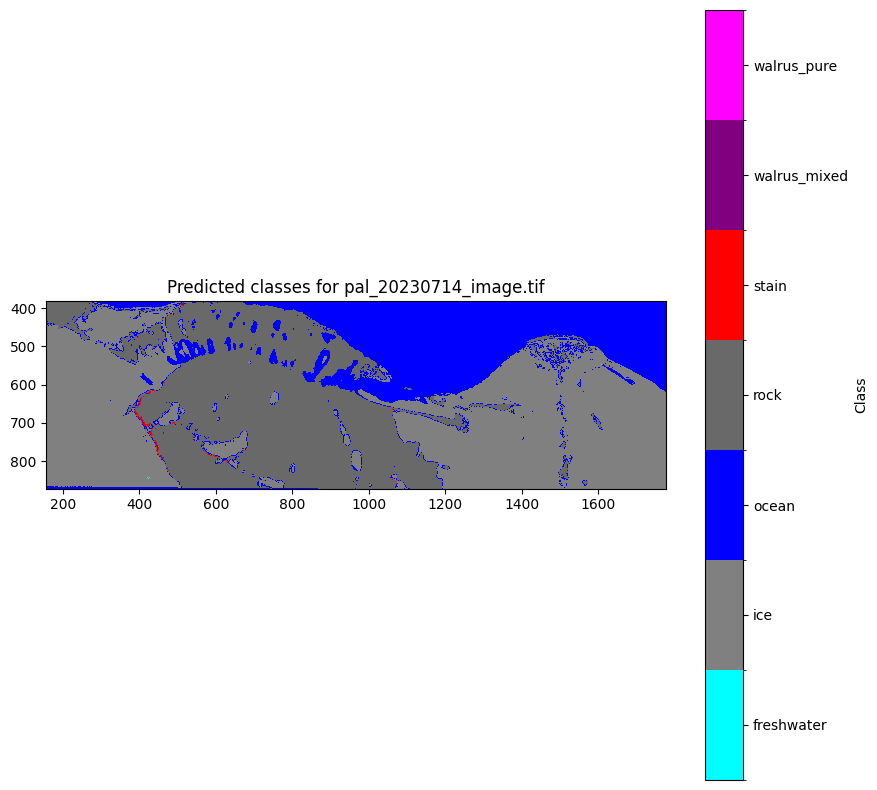

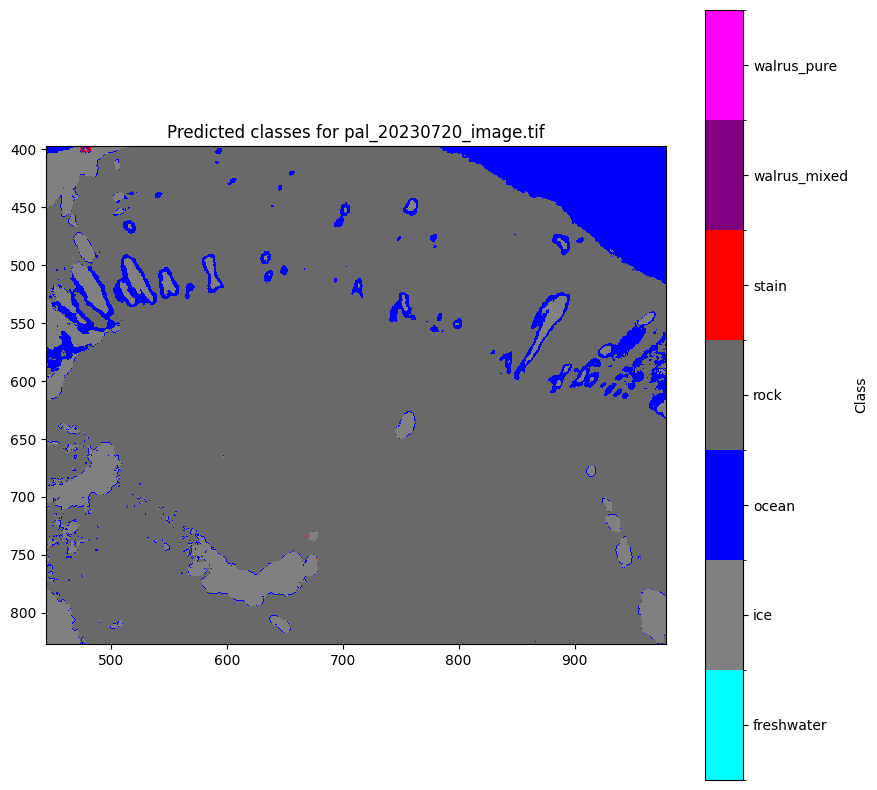

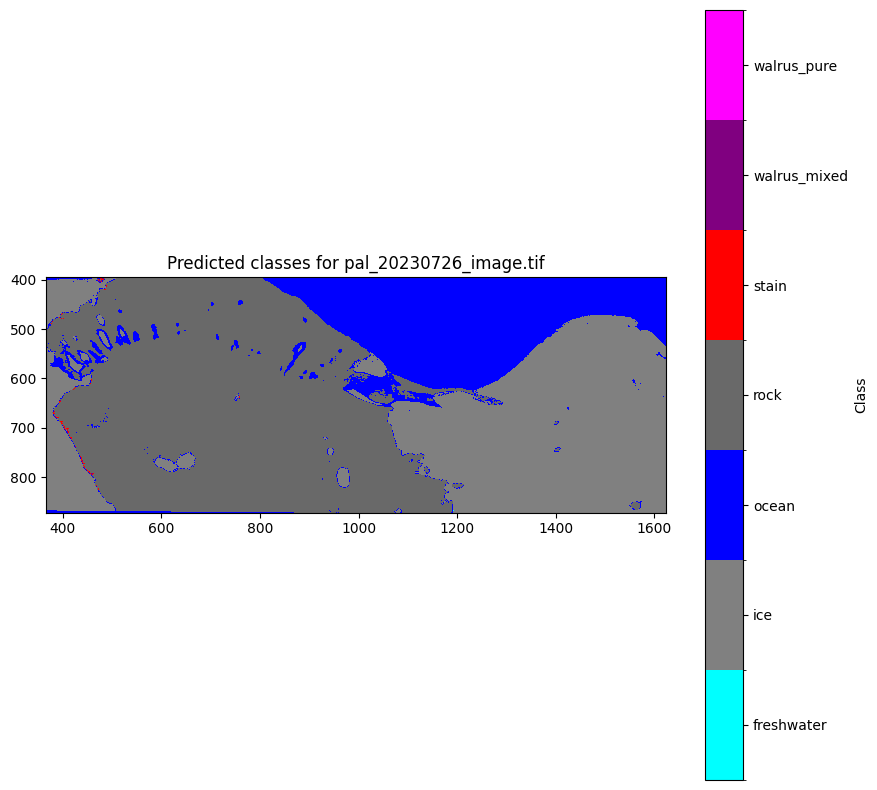

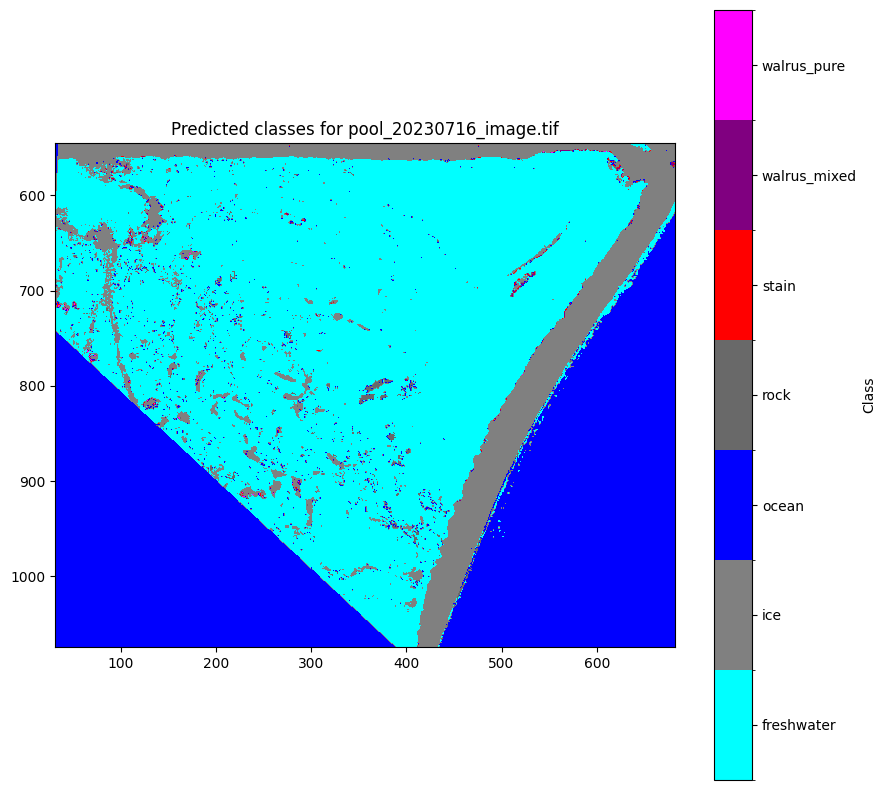

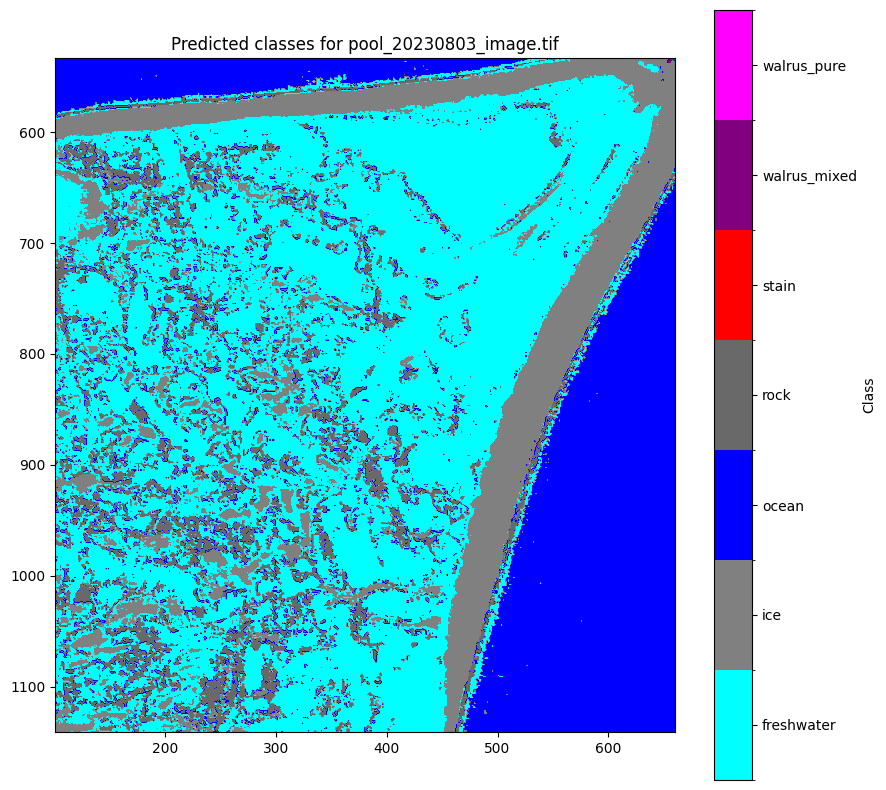

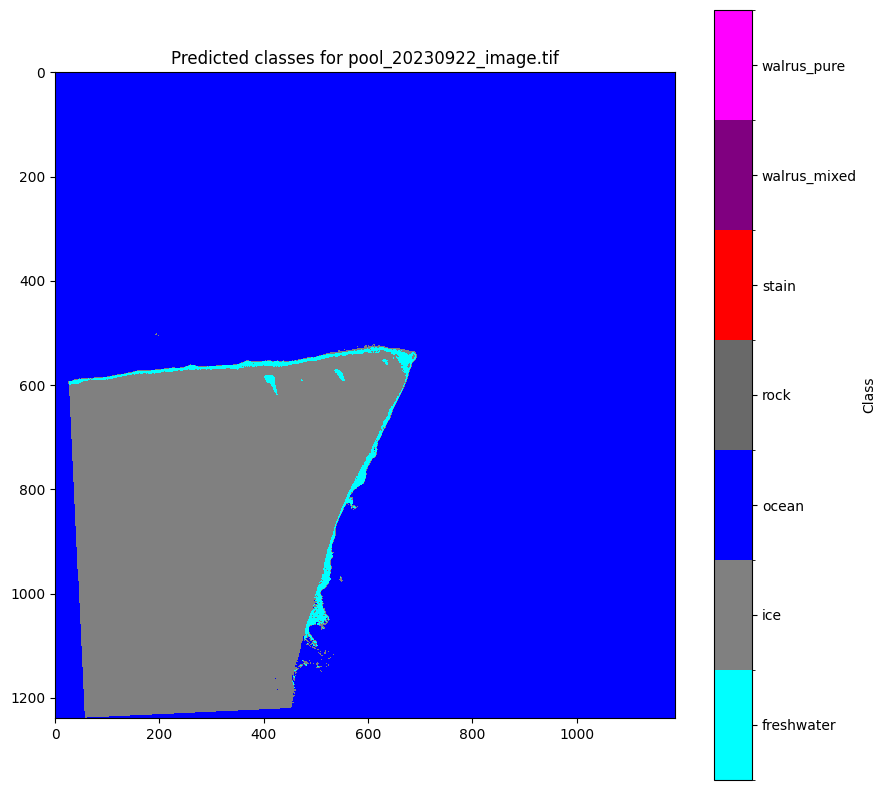

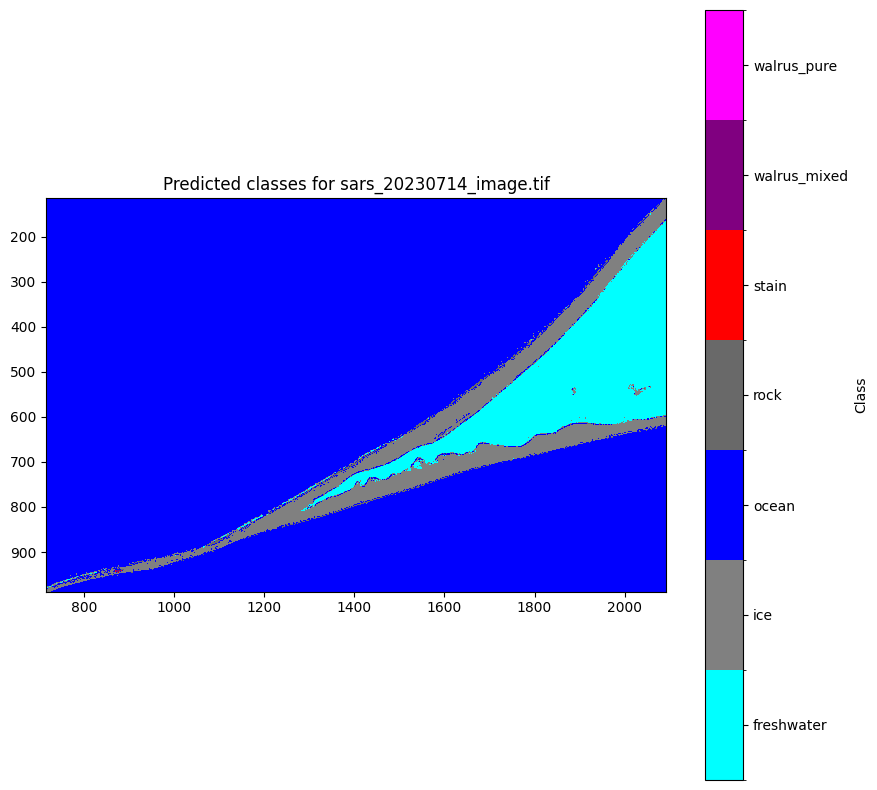

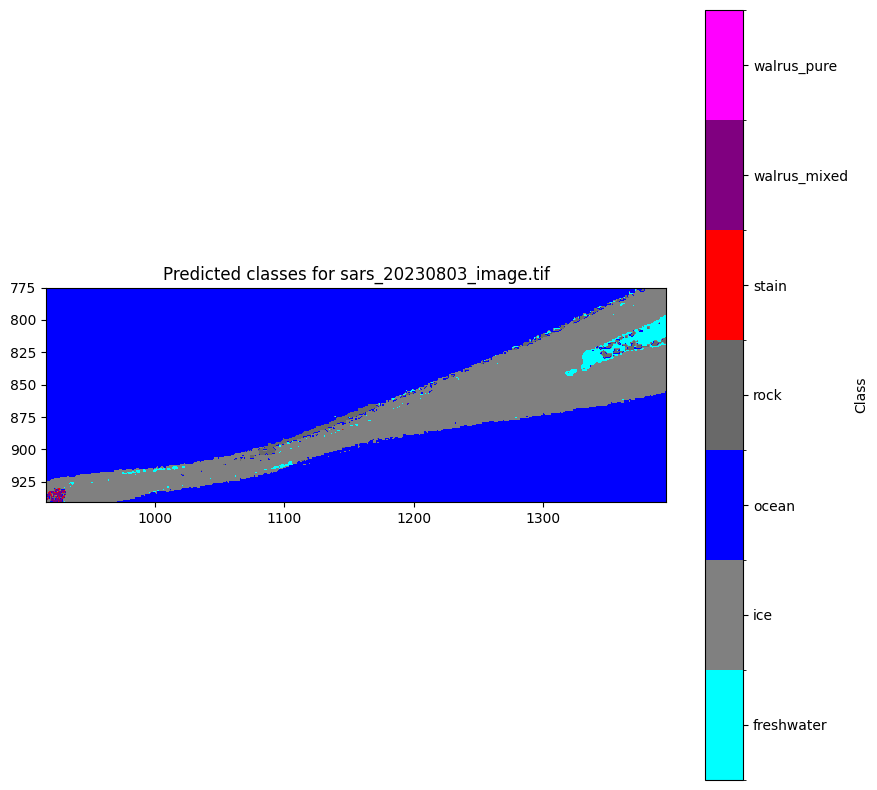

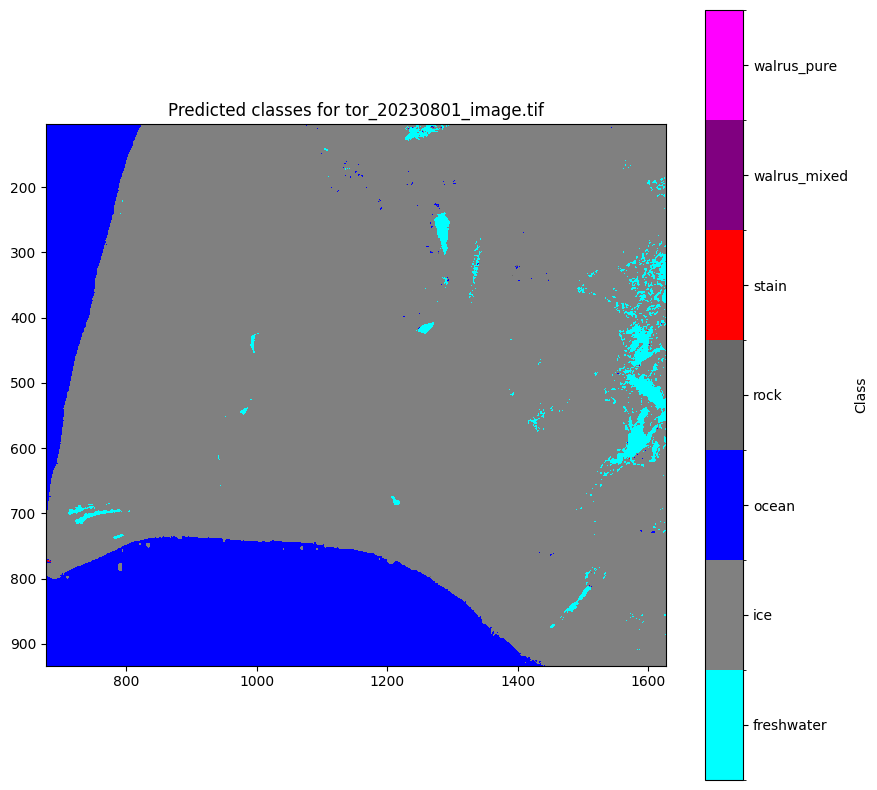

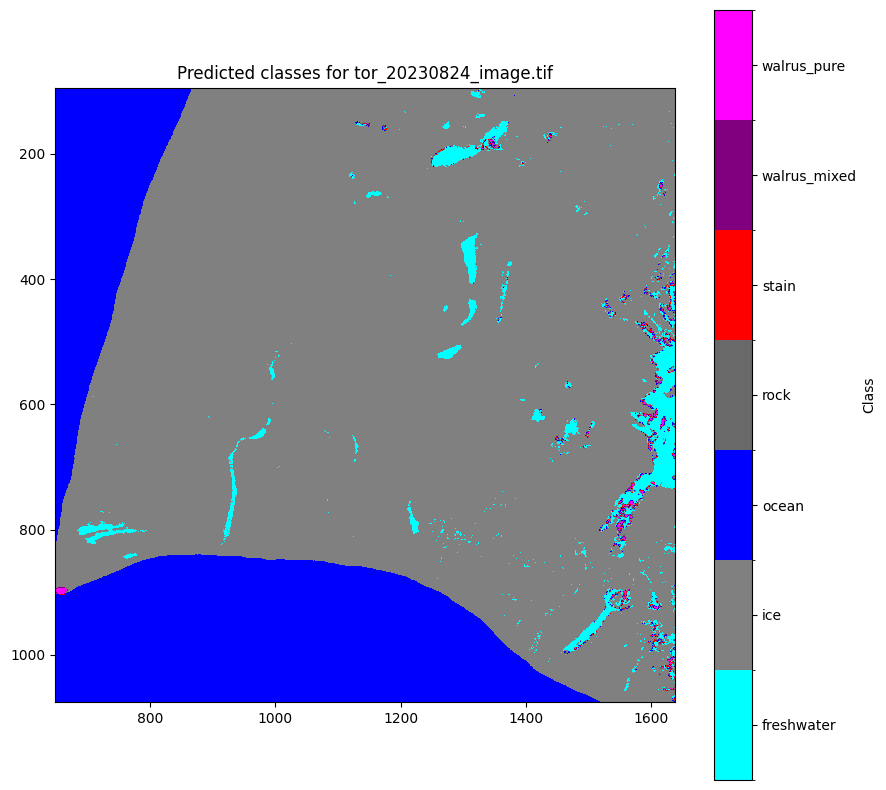

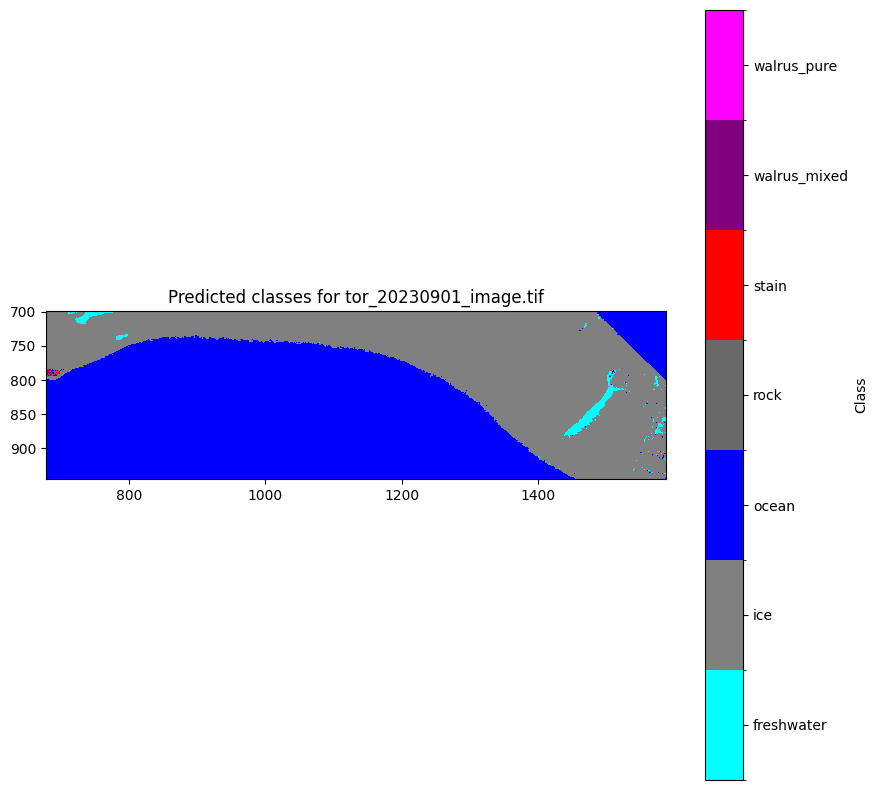

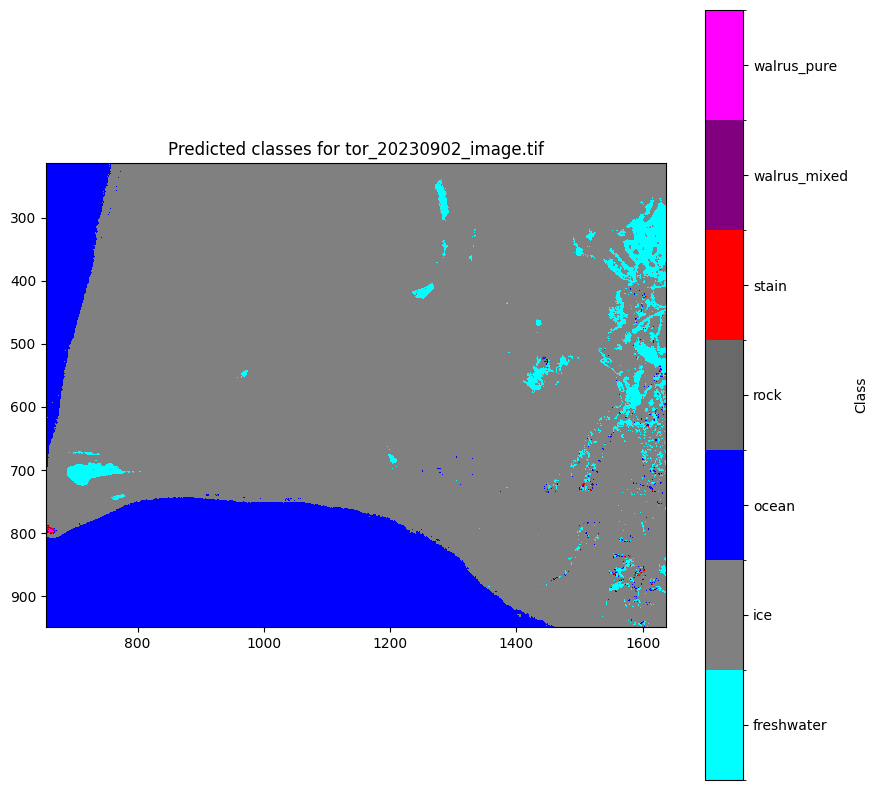

In [64]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define a color map for the labels
label_colors = {'ice': 'gray', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue', 'stain': 'red'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(le.classes_)+1)-0.5, ncolors=len(le.classes_))

def get_walrus_bounding_box(predicted_image, walrus_labels):
    # Find the indices where the labels are walrus_pure or walrus_mixed
    walrus_indices = np.isin(predicted_image, walrus_labels)
    # Get the coordinates of those indices
    walrus_coords = np.argwhere(walrus_indices)
    if walrus_coords.size == 0:
        return None  # No walrus found
    # Get the bounding box coordinates
    min_row, min_col = walrus_coords.min(axis=0)
    max_row, max_col = walrus_coords.max(axis=0)
    return (min_row, max_row, min_col, max_col)

walrus_labels = [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]

for image_path, predicted_image in predicted_images.items():
    bbox = get_walrus_bounding_box(predicted_image, walrus_labels)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    if bbox:
        min_row, max_row, min_col, max_col = bbox
        plt.xlim(min_col, max_col)
        plt.ylim(max_row, min_row)  # Note: Inverted y-axis in image plots
    plt.show()


trying again but with clipped images, and only one island, and smaller labels so less class imbalance 

In [68]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [69]:
# This is the shorter way of doing what is above, separate file names 
island_name, date = image_filename.split("_")

ValueError: too many values to unpack (expected 2)

In [48]:
# List of image and shapefile pairs
image_shapefile_pairs = [
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230714_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230714_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230720_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230720_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230731_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230731_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230923_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230923_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\moff_20230717_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\moff_20230717_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pal_20230714_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pal_20230714_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pal_20230720_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pal_20230720_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pal_20230726_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pal_20230726_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pool_20230716_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pool_20230716_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pool_20230803_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pool_20230803_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pool_20230922_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pool_20230922_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\sars_20230714_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\sars_20230714_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\sars_20230803_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\sars_20230803_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\tor_20230801_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\tor_20230801_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\tor_20230824_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\tor_20230824_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\tor_20230901_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\tor_20230901_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\tor_20230902_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\tor_20230902_train.shp")
]

In [50]:
for image_file, shapefile_file in image_shapefile_pairs:
    try:
        # Read image
        with rasterio.open(image_file) as img:
            bands = img.read(1, 2, 3)
            transform = img.transform
    except rasterio.errors.RasterioIOError:
        print(f"Error: Unable to open file {image_file}")
        continue
    
    # Read shapefile
    try:
        img, roi = get_raster_and_mask(image_file, shapefile_file)
    except Exception as e:
        print(f"Error processing {image_file} and {shapefile_file}: {e}")
        continue
    

AttributeError: 'int' object has no attribute 'ndim'

In [46]:
import rasterio

def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        # Assume the image has three dimensions (bands, rows, columns)
        # If it's different, adjust accordingly
        image = image.transpose(1, 2, 0)  # Transpose to (rows, columns, bands) for easier indexing
        return image

import geopandas as gpd

def load_shapefile(shapefile_path):
    shapefile = gpd.read_file(shapefile_path)
    return shapefile


# Iterate through each image and its corresponding shapefile
for image_path, shapefile_path in file_pairs.items():
    # Load the image and shapefile
    img = load_image(image_path)
    shapefile = load_shapefile(shapefile_path)
    
    # Call the prepare_training_data function
    training_data, training_labels = prepare_training_data(img, shapefile)
    
    # Check the number of samples
    n_samples = len(training_data)
    print(f"Number of samples in the training data for {image_path}: {n_samples}")


ValueError: x attribute access only provided for Point geometries

In [42]:

x   # Call the prepare_training_data function
training_data, training_labels = prepare_training_data(image_paths, shapefile_paths)

# Check the number of samples
n_samples = len(training_data)
print(f"Number of samples in the training data: {n_samples}")


AttributeError: 'list' object has no attribute 'geometry'

In [32]:
# Function to load an image and its corresponding shapefile
def load_image_and_shapefile(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        meta = src.meta

    shapefile = gpd.read_file(shapefile_path)
    return image, meta, shapefile

In [40]:
# Function to prepare the training data
def prepare_training_data(image, shapefile):
    coords = [(x, y) for x, y in zip(shapefile.geometry.x, shapefile.geometry.y)]
    labels = shapefile['label'].values
    
    training_data = []
    training_labels = []

    for (x, y), label in zip(coords, labels):
        row, col = rasterio.transform.rowcol(meta['transform'], x, y)
        if 0 <= row < image.shape[1] and 0 <= col < image.shape[2]:
            training_data.append(image[:, row, col])
            training_labels.append(label)
    
    return np.array(training_data), np.array(training_labels)


NameError: name 'img' is not defined

In [34]:
# Load and prepare data from all pairs
training_data = []
training_labels = []

for image_path, shapefile_path in file_pairs.items():
    image, meta, shapefile = load_image_and_shapefile(image_path, shapefile_path)
    data, labels = prepare_training_data(image, shapefile)
    training_data.append(data)
    training_labels.append(labels)

training_data = np.vstack(training_data)
training_labels = np.hstack(training_labels)

ValueError: need at least one array to concatenate

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(training_labels)

In [ ]:
# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(training_data, encoded_labels)

In [ ]:


# Function to predict the entire image
def predict_image(image, model, label_encoder):
    n_bands, n_rows, n_cols = image.shape
    reshaped_image = image.reshape(n_bands, -1).T
    predictions = model.predict(reshaped_image)
    decoded_predictions = label_encoder.inverse_transform(predictions)
    return decoded_predictions.reshape(n_rows, n_cols)

# Function to create an RGB image from multi-band image
def create_rgb_image(image, bands=[0, 1, 2]):
    return np.stack([image[bands[0]], image[bands[1]], image[bands[2]]], axis=-1)

# Function to visualize the original image and the prediction
def visualize_predictions(image, prediction, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original image (use first 3 bands as RGB)
    axes[0].set_title('Original Image')
    rgb_image = create_rgb_image(image)
    show(rgb_image, ax=axes[0])

    # Prediction
    axes[1].set_title(title)
    unique_labels = np.unique(prediction)
    cmap = plt.get_cmap('tab20', len(unique_labels))
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    int_prediction = np.vectorize(label_to_int.get)(prediction)
    im = axes[1].imshow(int_prediction, cmap=cmap)
    cbar = plt.colorbar(im, ax=axes[1], ticks=np.arange(len(unique_labels)))
    cbar.ax.set_yticklabels


In [65]:
import glob
import os
import re
import rasterio
import geopandas as gpd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import mapping

In [66]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [67]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [68]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Extract island name and date, and match files
image_data = {extract_island_and_date(os.path.basename(image)): image for image in image_paths}
shapefile_data = {extract_island_and_date(os.path.basename(shapefile)): shapefile for shapefile in shapefile_paths}

# Pair the images and shapefiles
for key in image_data.keys():
    if key in shapefile_data:
        file_pairs[image_data[key]] = shapefile_data[key]


In [69]:
# Function to load an image and its corresponding shapefile
def load_image_and_shapefile(image_path, shapefile_path):
    # Load the image
    with rasterio.open(image_path) as src:
        image = src.read()
        image_meta = src.meta

    # Load the shapefile
    shapefile = gpd.read_file(shapefile_path)

    return image, image_meta, shapefile

# Function to extract features and labels from the images and shapefiles
def extract_features_and_labels(image, shapefile, meta):
    features = []
    labels = []

    for _, row in shapefile.iterrows():
        geom = row['geometry']
        label = row['label']

        # Create a mask of the geometry
        mask = rasterio.features.geometry_mask([mapping(geom)], transform=meta['transform'], invert=True, out_shape=(meta['height'], meta['width']))

        # Extract pixel values within the mask
        masked_pixels = image[:, mask]

        # Add to features and labels
        for pixel in masked_pixels.T:
            features.append(pixel)
            labels.append(label)

    return np.array(features), np.array(labels)


In [70]:
# Possible run this - this cousd work  
# Function to train the random forest model
def train_random_forest(features, labels):
    # Encode labels
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    return clf, le

In [71]:
# Function to predict labels for the entire image
def predict_image(image, model, label_encoder):
    height, width = image.shape[1], image.shape[2]
    flat_pixels = image.reshape(image.shape[0], -1).T
    predictions = model.predict(flat_pixels)
    prediction_image = predictions.reshape(height, width)
    
    # Decode predictions back to text labels
    decoded_predictions = label_encoder.inverse_transform(predictions)
    prediction_image_text = decoded_predictions.reshape(height, width)

    return prediction_image_text


In [78]:
def visualize_predictions(image, prediction, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    axes[0].set_title('Original Image')
    show(image, ax=axes[0])

    # Prediction
    axes[1].set_title(title)
    show(prediction, ax=axes[1])

    plt.show()


In [73]:
# Main script
all_features = []
all_labels = []


In [74]:
# Load, extract features, and labels for each image-shapefile pair
for image_path, shapefile_path in file_pairs.items():
    image, meta, shapefile = load_image_and_shapefile(image_path, shapefile_path)
    features, labels = extract_features_and_labels(image, shapefile, meta)
    all_features.append(features)
    all_labels.append(labels)


In [75]:
# Combine all features and labels
all_features = np.vstack(all_features)
all_labels = np.concatenate(all_labels)

In [76]:
# Train the model
model, label_encoder = train_random_forest(all_features, all_labels)


Accuracy: 99.89%


In [89]:
# Function to create an RGB image from multi-band image
def create_rgb_image(image, bands=[0, 1, 2]):
    if image.shape[2] < 3:
        raise ValueError("The image does not have enough bands to create an RGB image")
    return np.stack([image[:, :, bands[0]], image[:, :, bands[1]], image[:, :, bands[2]]], axis=-1)


TypeError: Image data of dtype <U12 cannot be converted to float

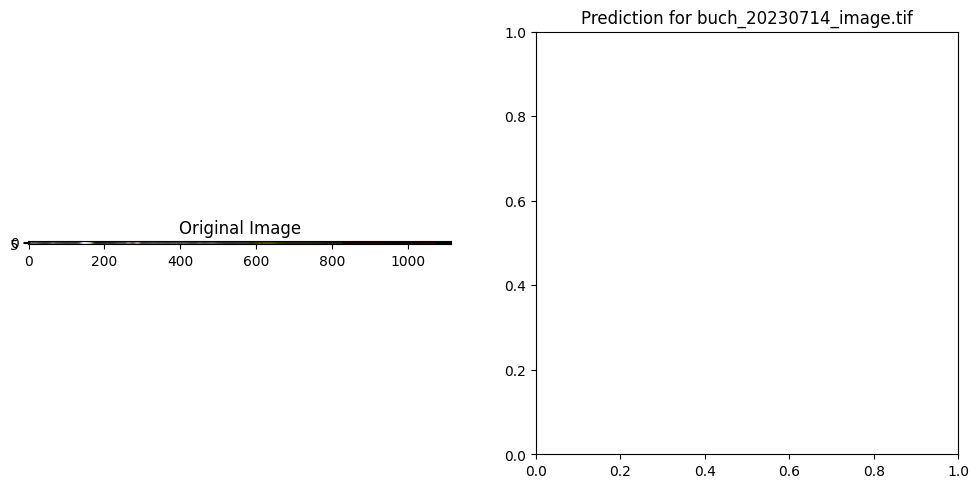

In [92]:
# Load, extract features, and labels for each image-shapefile pair
for image_path, shapefile_path in file_pairs.items():
    image, meta, shapefile = load_image_and_shapefile(image_path, shapefile_path)
    features, labels = extract_features_and_labels(image, shapefile, meta)
    # Predict labels for the entire image
    prediction = predict_image(image, model, label_encoder)
    # Visualize the prediction
    title = f"Prediction for {os.path.basename(image_path)}"
    visualize_predictions(image, prediction, title)


IndexError: index 4 is out of bounds for axis 2 with size 3

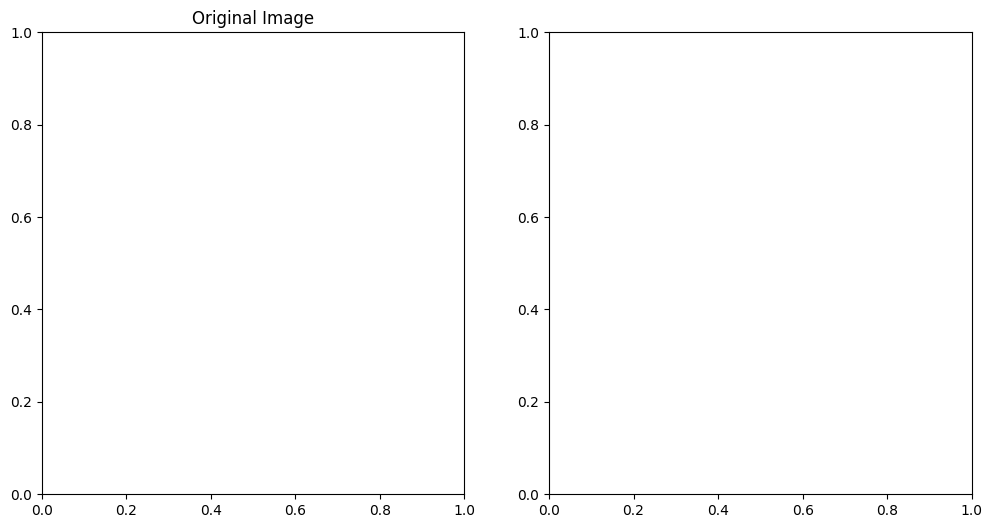

In [93]:

for image_path, shapefile_path in file_pairs.items():
    image, meta, shapefile = load_image_and_shapefile(image_path, shapefile_path)
    
    # Select 3 out of 8 bands for visualization
    selected_bands = [0, 1, 2]
    rgb_image = create_rgb_image(image, bands=selected_bands)
    
    # Predict labels for the entire image
    prediction = predict_image(image, model, label_encoder)
    
    # Visualize the original image and the prediction
    title = f"Prediction for {os.path.basename(image_path)}"
    visualize_predictions(rgb_image, prediction, title)


In [96]:
def create_rgb_image(image, bands=[4, 3, 2]):
    num_bands = image.shape[0]
    if num_bands < 3:
        raise ValueError("The image does not have enough bands to create an RGB image")

    # Ensure the specified bands are within the available bands
    bands = [b if b < num_bands else 0 for b in bands]

    rgb_image = image[bands, :, :].astype(np.float32)

    # Normalize each band
    for i in range(3):
        rgb_image[i] /= np.max(rgb_image[i])

    return np.transpose(rgb_image, (1, 2, 0))


TypeError: Image data of dtype <U12 cannot be converted to float

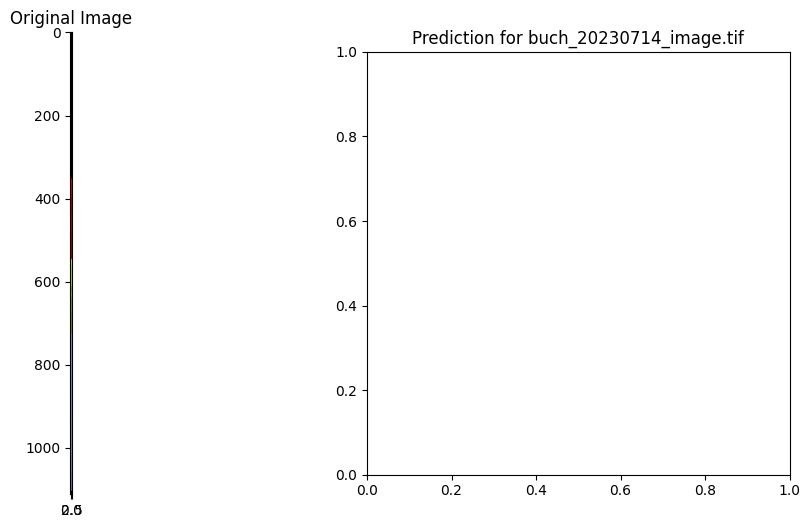

In [97]:
# Main script
for image_path, shapefile_path in file_pairs.items():
    image, meta, shapefile = load_image_and_shapefile(image_path, shapefile_path)
    
    # Select 3 out of 8 bands for visualization
    selected_bands = [0, 1, 2]
    rgb_image = create_rgb_image(image, bands=selected_bands)
    
    # Predict labels for the entire image
    prediction = predict_image(image, model, label_encoder)
    
    # Visualize the original image and the prediction
    title = f"Prediction for {os.path.basename(image_path)}"
    visualize_predictions(rgb_image, prediction, title)


In [98]:
def visualize_predictions(image, prediction, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original Image
    axes[0].set_title('Original Image')
    axes[0].imshow(image)
    axes[0].axis('off')
    
    # Prediction
    # Assuming prediction is a string label, decode it to numerical values
    decoded_prediction = label_encoder.transform([prediction]) if isinstance(prediction, str) else prediction
    axes[1].set_title(title)
    axes[1].imshow(decoded_prediction, cmap='viridis')  # Assuming prediction is a 2D array
    axes[1].axis('off')
    
    plt.show()


TypeError: Image data of dtype <U12 cannot be converted to float

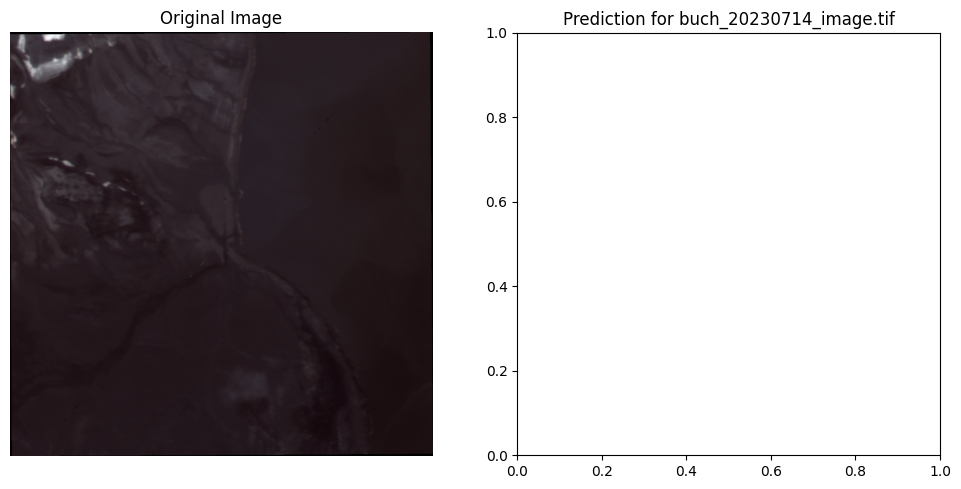

In [99]:
# Main script
for image_path, shapefile_path in file_pairs.items():
    image, meta, shapefile = load_image_and_shapefile(image_path, shapefile_path)
    
    # Select 3 out of 8 bands for visualization
    selected_bands = [0, 1, 2]
    rgb_image = create_rgb_image(image, bands=selected_bands)
    
    # Predict labels for the entire image
    prediction = predict_image(image, model, label_encoder)
    
    # Visualize the original image and the prediction
    title = f"Prediction for {os.path.basename(image_path)}"
    visualize_predictions(rgb_image, prediction, title)


TypeError: Invalid shape (1115, 3, 8) for image data

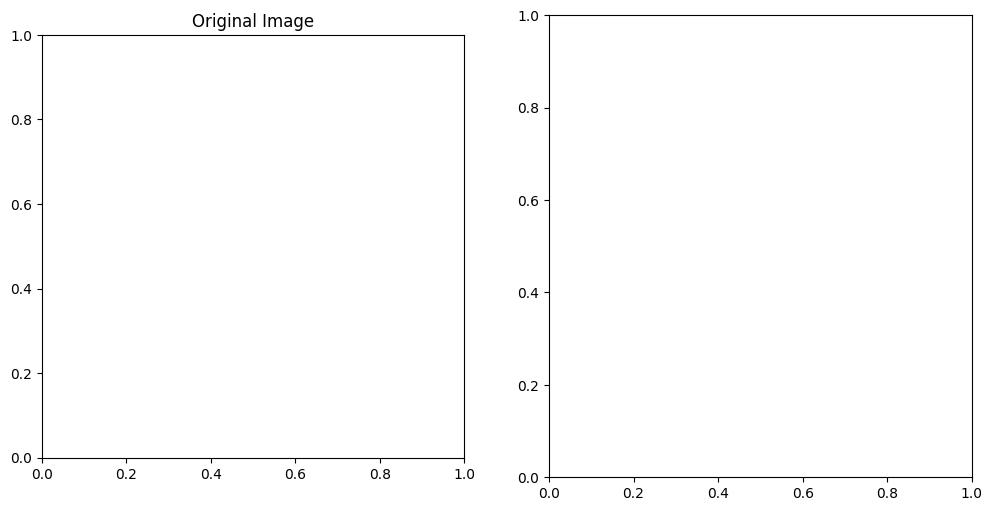

In [90]:

# Function to visualize the original image and the prediction
def visualize_predictions(image, prediction, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original image (use first 3 bands as RGB)
    axes[0].set_title('Original Image')
    rgb_image = create_rgb_image(image)
    show(rgb_image, ax=axes[0])

    # Prediction
    axes[1].set_title(title)
    unique_labels = np.unique(prediction)
    cmap = plt.get_cmap('tab20', len(unique_labels))
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    int_prediction = np.vectorize(label_to_int.get)(prediction)
    im = axes[1].imshow(int_prediction, cmap=cmap)
    cbar = plt.colorbar(im, ax=axes[1], ticks=np.arange(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)

    plt.show()

# Predict and visualize for each image
for image_path in file_pairs.keys():
    image, meta, _ = load_image_and_shapefile(image_path, file_pairs[image_path])
    prediction = predict_image(image, model, label_encoder)
    
    title = f"Prediction for {os.path.basename(image_path)}"
    visualize_predictions(image, prediction, title)


TypeError: Invalid shape (1115, 3, 8) for image data

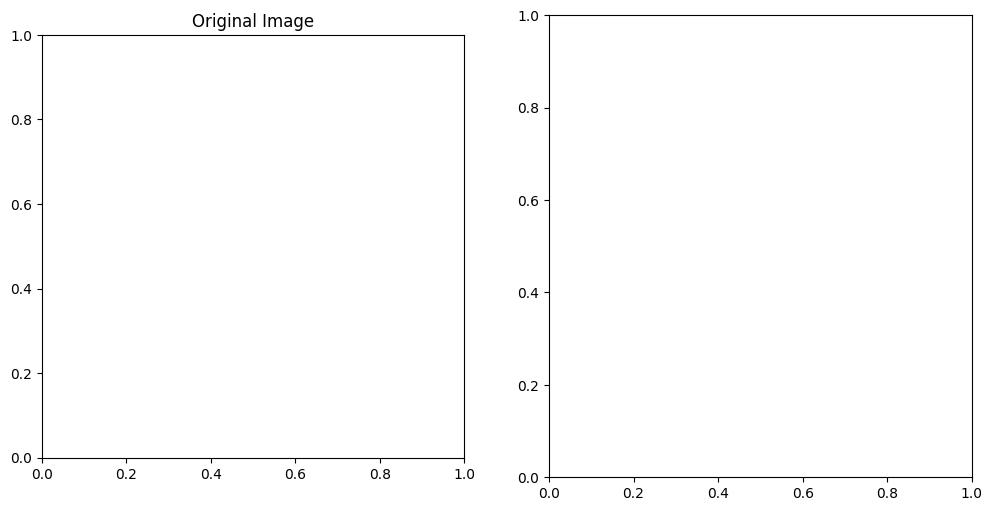

In [88]:
# Function to visualize the original image and the prediction
def visualize_predictions(image, prediction, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original image (use first 3 bands as RGB)
    axes[0].set_title('Original Image')
    rgb_image = create_rgb_image(image)
    show(rgb_image, ax=axes[0])

    # Prediction
    axes[1].set_title(title)
    unique_labels = np.unique(prediction)
    cmap = plt.get_cmap('tab20', len(unique_labels))
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    int_prediction = np.vectorize(label_to_int.get)(prediction)
    im = axes[1].imshow(int_prediction, cmap=cmap)
    cbar = plt.colorbar(im, ax=axes[1], ticks=np.arange(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)

    plt.show()

# Predict and visualize for each image
for image_path in file_pairs.keys():
    image, meta, _ = load_image_and_shapefile(image_path, file_pairs[image_path])
    prediction = predict_image(image, model, label_encoder)
    
    title = f"Prediction for {os.path.basename(image_path)}"
    visualize_predictions(image, prediction, title)

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.preprocessing import LabelEncoder

# Function to create an RGB image
def create_rgb_image(image, bands=(4, 3, 2)):  # Default to RGB for Sentinel-2
    rgb_image = image[:, :, bands].astype(np.float32)
    for i in range(3):
        rgb_image[:, :, i] /= np.max(rgb_image[:, :, i])  # Normalize each band
    return rgb_image

# Function to visualize predictions
def visualize_predictions(image, prediction, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    axes[0].set_title('Original Image')
    rgb_image = create_rgb_image(image)
    axes[0].imshow(rgb_image)
    
    # Prediction
    axes[1].set_title(title)
    axes[1].imshow(prediction, cmap='viridis')  # Assuming prediction is a 2D array
    
    plt.show()
    


# Assuming images are in the directory 'images' and we have a trained 'model' and 'label_encoder'
image_dir = 'images'
model = None  # Placeholder for the actual model
label_encoder = LabelEncoder().fit([0, 1])  # Assuming binary classification for this example

# Load images
images = load_images(image_dir)

# Visualize each image with its prediction
for i, image in enumerate(images):
    prediction = predict_image(image, model, label_encoder)
    title = f"Prediction for image_{i}.tif"
    visualize_predictions(image, prediction, title)


NameError: name 'load_images' is not defined

In [ ]:
# Function to predict labels for the entire image
def predict_image(image, model):
    height, width = image.shape[1], image.shape[2]
    flat_pixels = image.reshape(image.shape[0], -1).T
    predictions = model.predict(flat_pixels)
    prediction_image = predictions.reshape(height, width)

    return prediction_image


In [ ]:
# Function to visualize the original image and the prediction
def visualize_predictions(image, prediction):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    axes[0].set_title('Original Image')
    show(image, ax=axes[0])

    # Prediction
    axes[1].set_title('Prediction')
    axes[1].imshow(prediction, cmap='tab20')

    plt.show()


In [ ]:

# Main script
all_features = []
all_labels = []


In [ ]:
# Load, extract features, and labels for each image-shapefile pair
for image_path, shapefile_path in file_pairs.items():
    image, meta, shapefile = load_image_and_shapefile(image_path, shapefile_path)
    features, labels = extract_features_and_labels(image, shapefile, meta)
    all_features.append(features)
    all_labels.append(labels)


In [ ]:
# Combine all features and labels
all_features = np.vstack(all_features)
all_labels = np.concatenate(all_labels)


In [ ]:
# Train the model
model = train_random_forest(all_features, all_labels)


In [ ]:

# Predict and visualize for each image
for image_path in file_pairs.keys():
    image, meta, _ = load_image_and_shapefile(image_path, file_pairs[image_path])
    prediction = predict_image(image, model)
    visualize_predictions(image, prediction)


In [25]:
import rasterio
from rasterio import features
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib
import glob
import pandas as pd
import os
import re
from skimage import exposure
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

In [48]:
def get_raster_and_mask(tif_file, shp_file):
    # Load shapefile and check contents
    shp_df = gpd.read_file(shp_file)
    print(f"Loaded shapefile: {shp_file}")
    print(shp_df.head())  # Print first few rows of the shapefile

    # Open raster file and check CRS
    rstr = rasterio.open(tif_file)
    print(f"Loaded raster: {tif_file} with CRS {rstr.crs}")

    # Ensure shapefile CRS matches raster CRS
    if shp_df.crs != rstr.crs:
        print("CRS mismatch, reprojecting shapefile...")
        shp_df = shp_df.to_crs(rstr.crs)

    # Convert 'label' field to numeric, handling non-numeric values
    shp_df['label'] = pd.to_numeric(shp_df['label'], errors='coerce').fillna(0).astype(int)
    print(shp_df['label'].value_counts())  # Print label distribution

    # Read the raster data as an array
    out_arr = rstr.read()

    # Rasterize the shapefile geometries into a mask
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )

    print("Mask unique values and counts:", np.unique(mask, return_counts=True))  # Print unique values in mask

    return out_arr, mask


In [49]:
# Specify the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")


In [50]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [51]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Extract island name and date, and match files
image_data = {extract_island_and_date(os.path.basename(image)): image for image in image_paths}
shapefile_data = {extract_island_and_date(os.path.basename(shapefile)): shapefile for shapefile in shapefile_paths}


In [52]:
# Prepare training data
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    img = img.transpose(1, 2, 0)
    n_samples = (roi > 0).sum()
    labels = np.unique(roi[roi > 0])
    print(f"We have {n_samples} samples")
    print(f"The training data includes {labels.size} classes: {labels}")

for (image_island, image_date), image_path in image_data.items():
    if (image_island, image_date) in shapefile_data:
        file_pairs[image_path] = shapefile_data[(image_island, image_date)]

print("Paired file paths:", file_pairs)

Loaded shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
   Id        label                                           geometry
0   0  walrus_pure  POLYGON ((506954.882 8736869.728, 506957.199 8...
1   0        ocean  POLYGON ((507675.484 8738207.362, 508285.009 8...
2   0        ocean  POLYGON ((507321.771 8737318.426, 507908.398 8...
3   0        ocean  POLYGON ((508233.977 8736192.130, 508447.055 8...
4   0   freshwater  POLYGON ((507727.552 8735966.696, 507768.275 8...
Loaded raster: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif with CRS EPSG:32634
label
0    19
Name: count, dtype: int64
Mask unique values and counts: (array([0], dtype=uint8), array([1240995], dtype=int64))
We have 0 samples
The training data includes 0 classes: []
Loaded shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
   Id         label                                           geometry
0   0

In [54]:
# Check if the image and shapefile paths are correct
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    print("Image path:", image_path)
    print("Shapefile path:", shapefile_path)
    # Add code to verify if the files exist and are accessible

# Inside the get_raster_and_mask function, add debug prints to check if data is being loaded correctly
def get_raster_and_mask(image_path, shapefile_path):
    print("Loading image:", image_path)
    # Add code to load image data
    print("Loading shapefile:", shapefile_path)
    # Add code to load shapefile data
    # Return image and mask data


Image path: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif
Shapefile path: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
Image path: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230720_image.tif
Shapefile path: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
Image path: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230731_image.tif
Shapefile path: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230731_train.shp
Image path: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230923_image.tif
Shapefile path: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230923_train.shp
Image path: C:\Users\Student\Documents\101_walrus_data\train\images\moff_20230717_image.tif
Shapefile path: C:\Users\Student\Documents\101_walrus_data\train\shapefile\moff_20230717_train.shp
Image path: C:\Users\Student\Documents\101_wa

In [53]:
# Add debug prints to check intermediate variables and processing steps
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    # Add debug prints to check img and roi
    print("Image shape:", img.shape)
    print("ROI shape:", roi.shape)
    # Add code for processing img and roi
    # Ensure processing steps are functioning as expected


Loaded shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
   Id        label                                           geometry
0   0  walrus_pure  POLYGON ((506954.882 8736869.728, 506957.199 8...
1   0        ocean  POLYGON ((507675.484 8738207.362, 508285.009 8...
2   0        ocean  POLYGON ((507321.771 8737318.426, 507908.398 8...
3   0        ocean  POLYGON ((508233.977 8736192.130, 508447.055 8...
4   0   freshwater  POLYGON ((507727.552 8735966.696, 507768.275 8...
Loaded raster: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif with CRS EPSG:32634
label
0    19
Name: count, dtype: int64
Mask unique values and counts: (array([0], dtype=uint8), array([1240995], dtype=int64))
Image shape: (8, 1115, 1113)
ROI shape: (1115, 1113)
Loaded shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
   Id         label                                           geometry
0   0  walr

In [61]:
# Check if image and shapefile data are consistent and aligned
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    # Add code to verify consistency of img and roi
    # Check spatial dimensions, coordinate systems, and alignment


Loading image: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif
Loading shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp


TypeError: cannot unpack non-iterable NoneType object

In [59]:
# Check if image and shapefile data are consistent and aligned
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    try:
        img, roi = get_raster_and_mask(image_path, shapefile_path)
        if img is None or roi is None:
            raise ValueError("Error: Image or ROI is None.")
        # Add code to verify consistency of img and roi
        # Check spatial dimensions, coordinate systems, and alignment
    except Exception as e:
        print(f"An error occurred for {image_path} and {shapefile_path}: {e}")
        # Handle the error or continue to the next iteration
        continue


Loading image: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif
Loading shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
An error occurred for C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp: cannot unpack non-iterable NoneType object
Loading image: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230720_image.tif
Loading shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
An error occurred for C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230720_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp: cannot unpack non-iterable NoneType object
Loading image: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230731_image.tif
Loading shapefile: C:\Users\Student\Documents

In [56]:
# Add print statements or use a debugger to inspect intermediate variables
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    # Add print statements to inspect img and roi
    print("Image:", img)
    print("ROI:", roi)
    # Use a debugger to step through the code and inspect variables


Loading image: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif
Loading shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp


TypeError: cannot unpack non-iterable NoneType object

In [ ]:

# Prepare training data
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    img = img.transpose(1, 2, 0)
    n_samples = (roi > 0).sum()
    labels = np.unique(roi[roi > 0])
    print(f"We have {n_samples} samples")
    print(f"The training data includes {labels.size} classes: {labels}")

for (image_island, image_date), image_path in image_data.items():
    if (image_island, image_date) in shapefile_data:
        file_pairs[image_path] = shapefile_data[(image_island, image_date)]

print("Paired file paths:", file_pairs)

import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np


def process_shapefile_raster_pair(shapefile_path, raster_path):
    print(f"Processing shapefile: {shapefile_path}")
    print(f"Processing raster: {raster_path}")

    # Read the shapefile
    shapefile = gpd.read_file(shapefile_path)

    # Define a mapping of labels to integers
    label_mapping = {
        "ice": 1,
        "ocean": 2,
        "freshwater": 3,
        "rock": 4,
        "stain": 5,
        "walrus_pure": 6,
        "Walrus_mixed": 7
    }

    # Map the labels to integers
    shapefile['label'] = shapefile['label'].map(label_mapping)

    # Read the raster
    with rasterio.open(raster_path) as raster:
        raster_crs = raster.crs
        raster_transform = raster.transform
        raster_shape = raster.shape

    print(f"Loaded shapefile: {shapefile_path}")
    print(shapefile.head())
    print(f"Loaded raster: {raster_path} with CRS {raster_crs}")

    # Rasterize shapefile
    shapes = [(geom, value) for geom, value in zip(shapefile.geometry, shapefile['label'])]
    mask = rasterize(
        shapes,
        out_shape=raster_shape,
        transform=raster_transform,
        fill=0,
        dtype=np.uint8
    )

    # Count unique values in the mask
    unique, counts = np.unique(mask, return_counts=True)
    print(f"Unique values in the mask: {unique}")

    return mask, unique


# Example usage
shapefile_path = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230714_train.shp"
raster_path = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230714_image.tif"
mask, unique = process_shapefile_raster_pair(shapefile_path, raster_path)



In [26]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [27]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


ValueError: invalid literal for int() with base 10: 'walrus_pure'

In [28]:
# Create dictionaries to store the image and shapefile paths with their keys
image_data = {extract_island_and_date(os.path.basename(image)): image for image in image_paths}
shapefile_data = {extract_island_and_date(os.path.basename(shapefile)): shapefile for shapefile in shapefile_paths}

# Create a dictionary to store paired image and shapefile paths
file_pairs = {key: (image_data[key], shapefile_data[key]) for key in image_data if key in shapefile_data}


In [29]:
# Define a dictionary to map labels to numeric identifiers
label_mapping = {
    'walrus_pure': 1,
    'walrus_mixed': 2,
    'ocean': 3,
    'freshwater': 4,
    'ice': 5,
    'rock': 6, 
    'stain': 7
    
}

In [30]:
# Define the function to process the image and shapefile pair
def process_files(tif_file, shp_file):
    shp_df = gpd.read_file(shp_file)
    rstr = rasterio.open(tif_file)
    shp_df = shp_df.to_crs(rstr.crs)

    # Map labels to numeric identifiers
    shp_df['label'] = shp_df['label'].map(label_mapping)

    # Print unique labels after mapping
    print(f"Processing {tif_file} and {shp_file}")
    print("Unique labels after mapping:", shp_df['label'].unique())

    out_arr = rstr.read()
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    return out_arr, mask

# Process each pair of files
for key, (image_path, shapefile_path) in file_pairs.items():
    out_arr, mask = process_files(image_path, shapefile_path)

Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
Unique labels after mapping: [1 3 4 5 6]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230720_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
Unique labels after mapping: [2 3 4 6 5]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230731_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230731_train.shp
Unique labels after mapping: [2 3 6 4 5]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230923_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230923_train.shp
Unique labels after mapping: [3 5 6 4]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\moff_20230717_image.tif and C:\Users\Student\Documents\101_

In [43]:
# Process each pair of files
for key, (image_path, shapefile_path) in file_pairs.items():
    out_arr, mask = process_files(image_path, shapefile_path)
    
    
print("Number of file pairs:", len(file_pairs))
print("File pairs:", file_pairs)


Number of file pairs: 0
File pairs: {}


In [42]:
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    img = img.transpose(1, 2, 0)
    
    # Print data types of values in roi array
    print("Data type of roi array:", roi.dtype)
    
    # Ensure numeric values in roi array
    if not np.issubdtype(roi.dtype, np.number):
        raise ValueError("Values in roi array are not numeric.")
    
    n_samples = (roi > 0).sum()
    
    # Print unique labels before rasterization
    print("Unique labels before rasterization:", np.unique(roi[roi > 0]))
    
    # Rasterize shapefile
    labels = np.unique(roi[roi > 0])
    
    print(f"We have {n_samples} samples")
    print(f"The training data includes {labels.size} classes: {labels}")


ValueError: invalid literal for int() with base 10: 'walrus_pure'

In [46]:
# Process each pair of files
for key, (image_path, shapefile_path) in file_pairs.items():
    out_arr, mask = process_files(image_path, shapefile_path)


In [47]:
print("Number of file pairs:", len(file_pairs))

# Process each pair of files
for key, (image_path, shapefile_path) in file_pairs.items():
    out_arr, mask = process_files(image_path, shapefile_path)

print("Processing complete.")


Number of file pairs: 0
Processing complete.


In [37]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Extract island name and date, and match files
image_data = {extract_island_and_date(os.path.basename(image)): image for image in image_paths}
shapefile_data = {extract_island_and_date(os.path.basename(shapefile)): shapefile for shapefile in shapefile_paths}

# Prepare training data
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    img = img.transpose(1, 2, 0)
    n_samples = (roi > 0).sum()
    labels = np.unique(roi[roi > 0])
    print(f"We have {n_samples} samples")
    print(f"The training data includes {labels.size} classes: {labels}")

for (image_island, image_date), image_path in image_data.items():
    if (image_island, image_date) in shapefile_data:
        file_pairs[image_path] = shapefile_data[(image_island, image_date)]

print("Paired file paths:", file_pairs)

ValueError: invalid literal for int() with base 10: 'walrus_pure'

test, from scratch 

In [20]:
import rasterio
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
from shapely.geometry import mapping

In [8]:
# Specify the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [9]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [10]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Extract island name and date, and match files
image_data = {extract_island_and_date(os.path.basename(image)): image for image in image_paths}
shapefile_data = {extract_island_and_date(os.path.basename(shapefile)): shapefile for shapefile in shapefile_paths}


In [15]:
# Load images and shapefiles, extract labeled pixels, and train the classifier
labeled_pixels = []
labels = []

for image_path, shapefile_path in file_pairs.values():
    with rasterio.open(image_path) as src:
        image = src.read()
    shp = gpd.read_file(shapefile_path)

    # Extract labeled pixels and their classes
    for _, row in shp.iterrows():
        coords = [json.loads(row.geometry.json)['coordinates']]
        label = row['label']
        pixels = rasterio.features.rasterize(coords, out_shape=image.shape, fill=label)
        labeled_pixels.append(pixels[np.nonzero(pixels)])
        labels.extend([label_mapping[label]] * len(pixels[np.nonzero(pixels)]))


In [18]:
# Function to load images and shapefiles
def load_data(image_data, shapefile_data):
    images = {}
    shapefiles = {}
    for key in image_data.keys():
        if key in shapefile_data:
            # Load image
            image_path = image_data[key]
            image = rasterio.open(image_path).read()
            images[key] = image

            # Load shapefile
            shapefile_path = shapefile_data[key]
            shapefile = gpd.read_file(shapefile_path)
            shapefiles[key] = shapefile

    return images, shapefiles
# Load all images and shapefiles
images, shapefiles = load_data(image_data, shapefile_data)

In [21]:
from rasterio.mask import mask
import numpy as np

def extract_training_data(images, shapefiles):
    training_data = []
    labels = []
    
    for key in images.keys():
        image = images[key]
        shapefile = shapefiles[key]
        
        for _, row in shapefile.iterrows():
            geom = [mapping(row['geometry'])]
            out_image, out_transform = mask(rasterio.open(image_data[key]), geom, crop=True)
            out_image = out_image.reshape((out_image.shape[0], -1)).T
            
            label = row['label']
            labels.extend([label] * out_image.shape[0])
            training_data.extend(out_image)
    
    return np.array(training_data), np.array(labels)

# Extract training data from all images and shapefiles
X, y = extract_training_data(images, shapefiles)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

  freshwater       0.99      0.46      0.63     70703
         ice       1.00      0.45      0.62    466867
       ocean       0.77      1.00      0.87   1175621
        rock       1.00      0.37      0.54     80949
       stain       0.00      0.00      0.00        37
walrus_mixed       1.00      0.10      0.18       335
 walrus_pure       0.97      0.43      0.60        90

    accuracy                           0.81   1794602
   macro avg       0.82      0.40      0.49   1794602
weighted avg       0.85      0.81      0.78   1794602


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
def classify_image(image, clf):
    n_bands, width, height = image.shape
    image_2d = image.reshape((n_bands, width * height)).T
    predictions = clf.predict(image_2d)
    return predictions.reshape((width, height))

classified_images = {}
for key in images.keys():
    image = images[key]
    classified_images[key] = classify_image(image, clf)


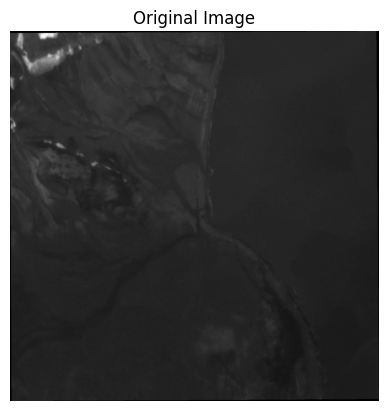

TypeError: Image data of dtype <U12 cannot be converted to float

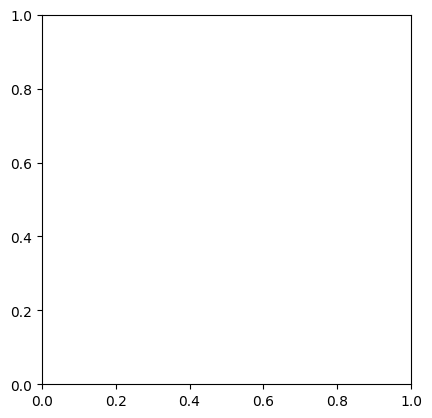

In [24]:
import matplotlib.pyplot as plt

def plot_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_classified_image(classified_image, title="Classified Image"):
    plt.imshow(classified_image, cmap='tab20')
    plt.title(title)
    plt.axis('off')
    plt.show()

def zoom_classified_image(classified_image, zoom_factor=2, center=None):
    width, height = classified_image.shape
    if center is None:
        center = (width // 2, height // 2)
    x, y = center
    x_start = max(x - width // (2 * zoom_factor), 0)
    y_start = max(y - height // (2 * zoom_factor), 0)
    x_end = min(x + width // (2 * zoom_factor), width)
    y_end = min(y + height // (2 * zoom_factor), height)
    zoomed_image = classified_image[x_start:x_end, y_start:y_end]
    plot_classified_image(zoomed_image, title="Zoomed Classified Image")

# Plot the first classified image
key = list(classified_images.keys())[0]
plot_image(images[key][0], title="Original Image")
plot_classified_image(classified_images[key], title="Classified Image")

# Zoom into a part of the classified image
zoom_classified_image(classified_images[key], zoom_factor=4, center=(100, 100))
